# DATA2 -  RF - baseline - Without standarization

## Features:
1. 'AGE' --> AGE
1. 'Gender\_num\_' --> GENDER


1. 'RAVLT\_immediate' --> RAVLT-im
1. 'AVDEL30MIN\_neuro' --> RAVLT-Delay
1. 'AVDELTOT\_neuro' --> RAVLT-Recog


1. 'TRAASCOR\_neuro' --> TMTA 
1. 'TRABSCOR\_neuro' --> TMTB
1. 'CATANIMSC\_neuro' --> CFT


1. 'LRHHC\_n\_long' --> HC
1. 'Apoe4_' --> APOE


1. 'GDTOTAL\_gds' --> GDS 
1. 'ANARTERR\_neuro' --> ANART 



1. 'Subgroup\_' --> same 
1. 'Subgroup\_num\_' --> same 
1. 'Usage\_' --> same 


---

**Resources**
1. DATA
    1. [data/data2](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2) - csv files downloaded from ADNI,
    1. [data/data2_FS](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2_FS) - FS result csv files,
    1. [data_zip/20201109_data2_file_versions](https://github.com/MMIV-ML/MCI-subgroups/blob/master/data/data_zip/20201109_data2_file_versions.pdf) - download ADNI web page screen shoot taken for downaloaded csv files (some of file neames are printed with dates),
1. RESULTS
    1. [results/20210420](https://github.com/MMIV-ML/MCI-subgroups/tree/master/results/20210420) - result folder,
    1. [results/202100420/README.md](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/README.md) - short description,
1. GOOGLE DRIVE
    1. [slides](https://docs.google.com/presentation/d/1aEK7M5BPe0RxWYskzQCEDbT4Mf-4mRRqQ5uJ_YuqRzg/edit#slide=id.p) - link to google slides (**OUT OF DATE, MUST BE UPDATED !!!**),
    1. [GoogleDrive](https://drive.google.com/drive/folders/1r8l2R88-0T8Xahk30iAgjBCWXvV1R2J-) - the main google drive slide folder,
1. GIT HUB
    1. [GitHub](https://github.com/MMIV-ML/MCI-subgroups) - the main repo folder,
1. [An overview](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/3.xx_RF_bl_comparison.pdf)


The latest changes (ver. 0.16):

    v 0.16
    
        - save, load `train` and `val` test split from a file. For a different fold number e.g. k={10, 20, 50, ...}
        
    v 0.15
    
    - feature perumtation function from scratch -> moved to the separate notebook: 3.02-data2-RF-bl-permutation.ipynb,
    - Conf_mat_ results (TP, TN, FP, FN), -> saved to external csv files,
    - Replace manual CV scores with built-in functions,
    - CV folds split loaded from file (to use in `bl` and `long`).
    
   *Created: 2021.03.18 / Updated: 2021.10.07*
   
---

#### IMPORTS

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import eli5
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import Image
from IPython.display import SVG #display, 
from eli5.sklearn import PermutationImportance

In [3]:
import mci_info as minfo
import mci_utils as mutils
# import mci_freesurfer as mfs
import mci_rf_bl as mrfbl

In [4]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence

#### GLOBAL PATH VARIABLES

In [5]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'data/data2'
DATA_DIR_FS = ROOT_DIR / 'data/data2_FS'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results/20201110'
# Results folder
RESULTS_DIR = ROOT_DIR/'results/20211111' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#### INSTALLED PACKAGES INFO

In [6]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels',
                'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: Ingrids-MacBook-Air-3.local
Operating system: Darwin, 64bit

Python path: /Users/ingridrye/opt/miniconda3/envs/mci/bin/python
Python version: 3.7.10 (default, Feb 26 2021, 10:16:00) 
[Clang 10.0.0 ]



module version
4          eli5  0.11.0
6    ipywidgets   7.6.3
10   matplotlib   3.3.4
13        numpy  1.20.1
15       pandas   1.2.4
16       pdpbox   0.2.1
20        scipy   1.6.2
21      seaborn  0.11.2
23      sklearn  0.24.2
24  statsmodels  0.13.1

---

## GLOBAL VARIABLES TO UPDATE IN EACH NOTEBOOK SEPARATELY!!! 

In [7]:
# features to feed the current model
FEATURES = ['AGE','RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
            'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro',
            'GDTOTAL_gds','ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_',
            'Subgroup_', 'Subgroup_num_', 'Usage_', 'PTGENDER',
           'Gender_num_'
           ]
FEATURE_NUMBER=len(FEATURES)
print(f'Number of selected features: {FEATURE_NUMBER}')


# Filename prefixes used to save all results (tables, images, ...)
FILE_NAME_PREFIX = '3.13_K50_RF_'
FILE_NAME_NUMBER = FILE_NAME_PREFIX.split('_')[0]

# Filename to load/save model. 
#Used if we load model from file with different name.
FILE_NAME_WITH_GS_MODEL_TO_LOAD = '3.13_K50_RF-master_'
# For model name the same as the current file prefix
# FILE_NAME_WITH_GS_MODEL_TO_LOAD = FILE_NAME_PREFIX

# random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# folds 
FOLDS = 50
# cross-validation fold split number to save in a csv file
FOLDS_LIST = [10, 20, 50]

# display all stuff
VERBOSE = True

Number of selected features: 16


---

## LOAD `CSV BASELINE` FILE

Load baseline csv file and restrict the whole bunch of avaliable features to those defined in the variable `FEATURES` that is defined above.

In [8]:
bl_name = CURRENT_DATA_DIR / 'bl.csv'
bl_loaded = pd.read_csv(bl_name, index_col=0)

bl_sel_feat = bl_loaded[FEATURES]

print(f'Subjects: \t{bl_sel_feat.shape[0]}')
print(f'Columns: \t{bl_sel_feat.shape[1]}')

Subjects: 	708
Columns: 	16


### RENAME COLUMNS USED IN MODEL 

In [10]:
new_names = ({"TRAASCOR_neuro":"TMTA",
              "TRABSCOR_neuro":"TMTB", 
              "Apoe4_":"APOE", "Gender_num_":"GENDER", 
              "CATANIMSC_neuro":"CFT",
              "GDTOTAL_gds":"GDS", 
              "LRHHC_n_long":"HC", 
              "ANARTERR_neuro":"ANART",
              "RAVLT_immediate":"RAVLT-Im", 
              "AVDEL30MIN_neuro":"RAVLT-Delay",
              "AVDELTOT_neuro":"RAVLT-Recog",
              "Subgroup_":"Subgroup_",
              "Subgroup_num_":"Subgroup_num_",
              "Usage_":"Usage_",
              "PTGENDER":"PTGENDER",
              "Gender_num_" : "GENDER"})

In [11]:
bl_sel_feat.rename(columns=new_names,
                      inplace=True)

In [12]:
bl_sel_feat.columns

Index(['AGE', 'RAVLT-Im', 'RAVLT-Delay', 'RAVLT-Recog', 'TMTA', 'TMTB', 'CFT',
       'GDS', 'ANART', 'HC', 'APOE', 'Subgroup_', 'Subgroup_num_', 'Usage_',
       'PTGENDER', 'GENDER'],
      dtype='object')

#### DISPLAY THE NAN VALUES IN THE WHOLE DATA FRAME

Insepect `NaN` values in the loaded dataframe.

In [13]:
if VERBOSE:
    print(bl_sel_feat.isnull().sum())
    bl_sel_feat.shape

AGE               0
RAVLT-Im          0
RAVLT-Delay       0
RAVLT-Recog       1
TMTA              0
TMTB             10
CFT               0
GDS               0
ANART             6
HC               14
APOE              0
Subgroup_         0
Subgroup_num_     0
Usage_            0
PTGENDER          0
GENDER            0
dtype: int64


### SPLIT BETWEEN TRAIN AND TEST SUBSETS

In [14]:
bl_train = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'train']
bl_test = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'test']

# a list of both sets, to ease further manipulation
bl_sets = [['Train set', bl_train], ['Test set', bl_test]]

---

## TRAIN / TEST SETS SHORT INFO

In [15]:
if VERBOSE: 
    print('Subjects in:')
    for name, bl in bl_sets:
        print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/bl_sel_feat.shape[0] * 100:.0f}%)')

    print('\n\nSubjects in each subgroup (with NaN included):\n')
    for name, bl in bl_sets:
        print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')

Subjects in:
	Train set:	566 (80%)
	Test set:	142 (20%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    305
cAD     261

*** Test set ***
sMCI    76
cAD     66



#### PRINT COLUMN NAMES INCLUDED IN BOTH SETS

In [16]:
minfo.included_feature_info(bl_train, pattern='adni-neuro-gds-long-_')

Total number of columns: 16



adni (#13) neuro (#0) gds (#0) long (#0)      ours (#3)
0           AGE                                    Subgroup_
1         ANART                                Subgroup_num_
2          APOE                                       Usage_
3           CFT                                             
4           GDS                                             
5        GENDER                                             
6            HC                                             
7      PTGENDER                                             
8   RAVLT-Delay                                             
9      RAVLT-Im                                             
10  RAVLT-Recog                                             
11         TMTA                                             
12         TMTB

---

## COUNT `NaN` VALUES IN TRAIN AND TEST SETS

In [17]:
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 566 rows) ***
AGE               0
RAVLT-Im          0
RAVLT-Delay       0
RAVLT-Recog       1
TMTA              0
TMTB             10
CFT               0
GDS               0
ANART             4
HC               13
APOE              0
Subgroup_         0
Subgroup_num_     0
Usage_            0
PTGENDER          0
GENDER            0

Rows in Train set: 566



*** NaN values in TEST SET set (out of 142 rows) ***
AGE              0
RAVLT-Im         0
RAVLT-Delay      0
RAVLT-Recog      0
TMTA             0
TMTB             0
CFT              0
GDS              0
ANART            2
HC               1
APOE             0
Subgroup_        0
Subgroup_num_    0
Usage_           0
PTGENDER         0
GENDER           0

Rows in Test set: 142





#### DISPLAY ALL SUBJECTS THAT CONTAIN `NaN` VALUES (BOTH SETS)

In [18]:
if VERBOSE:
    for name, bl in bl_sets:
        num = bl.isnull().sum().sum()
        #idx = bl.isnull().index
        print(f'*** {name.upper()} ***')
        display(bl.loc[bl.isnull().any(axis=1)].head(num))
        print()

*** TRAIN SET ***


AGE  RAVLT-Im  RAVLT-Delay  RAVLT-Recog  TMTA   TMTB   CFT  GDS  ANART  \
0     67.5      37.0          7.0         13.0  67.0  271.0  22.0  3.0    NaN   
20    83.3      21.0          0.0          7.0  34.0    NaN  16.0  2.0    2.0   
2284  69.0      29.0          1.0         11.0  54.0    NaN  11.0  5.0   34.0   
2948  61.7      21.0          0.0          6.0  57.0    NaN  10.0  2.0   25.0   
3367  65.5      20.0          4.0         12.0  26.0   75.0  14.0  1.0    NaN   
3437  75.2      27.0          3.0         10.0  22.0  112.0  22.0  0.0   14.0   
3523  81.6      28.0          3.0         10.0  61.0  170.0  14.0  0.0   24.0   
3547  76.6      33.0          8.0         14.0  40.0    NaN  13.0  3.0    3.0   
3639  66.7      55.0         11.0         14.0  33.0    NaN  28.0  3.0    1.0   
3652  71.0      20.0          0.0          8.0  60.0  176.0  20.0  1.0   24.0   
3855  76.6      38.0          7.0         15.0  39.0   82.0  13.0  1.0    NaN   
3883  56.3      53.0          9.0         15.0  30.0    NaN  24.0  4.0   20.0   
4133  68.9      47.0          8.0         11.0  23.0   50.0  17.0  2.0   26.0   
4153  86.4      17.0          2.0          7.0  72.0  300.0   5.0  5.0   38.0   
4484  69.4      38.0          5.0          9.0  49.0    NaN  18.0  1.0    5.0   
4713  71.9      42.0          4.0         15.0  28.0   91.0  20.0  1.0    3.0   
4814  76.8      39.0          7.0         14.0  30.0    NaN  22.0  3.0   27.0   
4913  71.3      44.0          0.0          NaN  28.0   45.0  20.0  1.0    2.0   
4930  68.1      54.0         13.0         15.0  27.0   65.0  17.0  0.0    4.0   
5077  77.6      26.0          3.0          7.0  53.0  180.0  23.0  5.0   27.0   
5353  79.3      25.0          0.0          3.0  38.0  120.0  17.0  4.0   14.0   
5530  65.4      34.0          2.0         15.0  41.0   67.0  11.0  3.0   14.0   
5831  71.9      28.0          5.0         11.0  36.0    NaN  21.0  0.0    6.0   
5855  85.3      24.0          3.0          8.0  72.0  298.0  11.0  2.0   27.0   
5978  55.0      42.0          7.0         13.0  23.0   65.0  22.0  1.0   10.0   
6111  75.3      18.0          0.0         13.0  56.0  114.0  16.0  0.0    NaN   
6140  69.0      29.0          0.0          4.0  27.0    NaN  16.0  5.0   12.0   

            HC  APOE Subgroup_  Subgroup_num_ Usage_ PTGENDER  GENDER  
0     0.003966   0.0      sMCI              0  train     Male       0  
20    0.003313   0.0      sMCI              0  train     Male       0  
2284  0.004512   1.0      sMCI              0  train   Female       1  
2948  0.005170   1.0      sMCI              0  train     Male       0  
3367  0.004289   0.0      sMCI              0  train     Male       0  
3437       NaN   0.0      sMCI              0  train     Male       0  
3523       NaN   1.0      sMCI              0  train     Male       0  
3547       NaN   0.0      sMCI              0  train     Male       0  
3639  0.005139   0.0      sMCI              0  train   Female       1  
3652       NaN   1.0      sMCI              0  train   Female       1  
3855  0.005280   1.0      sMCI              0  train     Male       0  
3883  0.005942   1.0      sMCI              0  train   Female       1  
4133       NaN   0.0      sMCI              0  train   Female       1  
4153       NaN   1.0      sMCI              0  train     Male       0  
4484  0.004482   0.0       cAD              1  train     Male       0  
4713       NaN   0.0      sMCI              0  train     Male       0  
4814  0.004488   0.0      sMCI              0  train   Female       1  
4913  0.003201   1.0       cAD              1  train     Male       0  
4930       NaN   0.0      sMCI              0  train     Male       0  
5077       NaN   0.0      sMCI              0  train     Male       0  
5353       NaN   1.0       cAD              1  train   Female       1  
5530       NaN   0.0      sMCI              0  train   Female       1  
5831  0.004059   1.0      sMCI              0  train     Male       0  
5855      


*** TEST SET ***


AGE  RAVLT-Im  RAVLT-Delay  RAVLT-Recog  TMTA   TMTB   CFT  GDS  ANART  \
3926  63.0      32.0          5.0         15.0  35.0  105.0  21.0  2.0    7.0   
6291  71.5      34.0          7.0         13.0  50.0  127.0  16.0  1.0    NaN   
6304  80.2      25.0          0.0         10.0  31.0   73.0   8.0  1.0    NaN   

            HC  APOE Subgroup_  Subgroup_num_ Usage_ PTGENDER  GENDER  
3926       NaN   1.0      sMCI              0   test     Male       0  
6291  0.004996   0.0      sMCI              0   test     Male       0  
6304  0.003878   0.0       cAD              1   test   Female       1

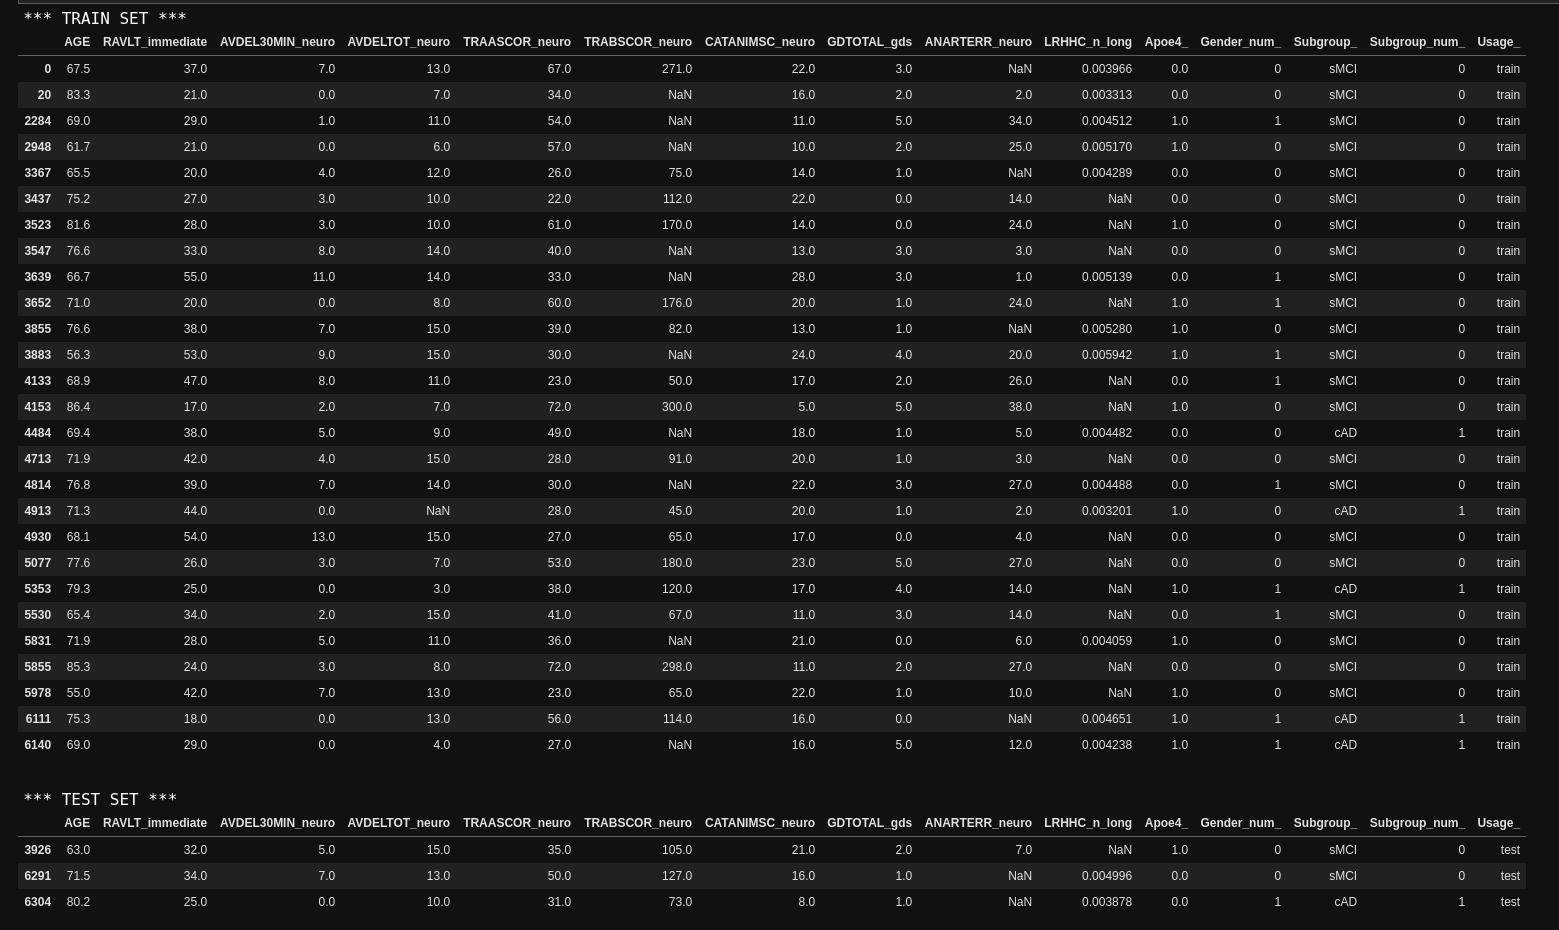

In [19]:
if VERBOSE:
    display(Image(filename="figs/assets/NaN_subjects.png", width=900))

## DROP `NaN` VALUES IN TRAIN AND TEST SETS (IF ANY)

In [20]:
print('\nSubjects number in both sets AFTER dropping NaN values:\n')
for name, bl in bl_sets:        
    bl.dropna(axis='rows', inplace=True)
    print(f' - {name}: {bl.shape[0]}\n')


Subjects number in both sets AFTER dropping NaN values:

 - Train set: 539

 - Test set: 139



#### COUNT `NaN` VALUES IN TRAIN AND TEST SETS (AFTER DROP `NaN` ROWS) 

In [21]:
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 539 rows) ***
AGE              0
RAVLT-Im         0
RAVLT-Delay      0
RAVLT-Recog      0
TMTA             0
TMTB             0
CFT              0
GDS              0
ANART            0
HC               0
APOE             0
Subgroup_        0
Subgroup_num_    0
Usage_           0
PTGENDER         0
GENDER           0

Rows in Train set: 539



*** NaN values in TEST SET set (out of 139 rows) ***
AGE              0
RAVLT-Im         0
RAVLT-Delay      0
RAVLT-Recog      0
TMTA             0
TMTB             0
CFT              0
GDS              0
ANART            0
HC               0
APOE             0
Subgroup_        0
Subgroup_num_    0
Usage_           0
PTGENDER         0
GENDER           0

Rows in Test set: 139





___

#### COUNT TRAIN / TEST  PERCENTAGE PROPORTION AFTER EXCLUDING NaN VALUES

In [22]:
print('Subjects in:')
for name, bl in bl_sets:
    print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/(bl_train.shape[0] + bl_test.shape[0]) * 100:.0f}%)')

print('\n\nSubjects in each subgroup (without NaN included):\n')
for name, bl in bl_sets:
    #print(f'*** {name} ***\n')
    mutils.textWrap(name)
    print()
    #print(f'{bl.Subgroup_.value_counts().to_string()}\n')
    #print(f'{bl.PTGENDER.value_counts().to_string()}\n')
    
    dfs = bl.Subgroup_.value_counts().rename_axis('Subgroup_').reset_index(name='#Nr')
    dfp = bl.PTGENDER.value_counts().rename_axis('PTGENDER').reset_index(name='#Nr')
    df = pd.concat([dfs,dfp],axis=1)
    display(df)
    

    cols1 = ['AGE']
    cols2 = ['PTGENDER'] 
    df1 = bl.groupby(['Subgroup_', 'PTGENDER'])
    a = df1[cols1].mean().round(2)
    c = df1[cols1].std().round(2)
    b = df1[cols2].count()
    
    df_abc = pd.concat([a,c,b],axis=1) 
    display(df_abc)

Subjects in:
	Train set:	539 (79%)
	Test set:	139 (21%)


Subjects in each subgroup (without NaN included):


#################
### Train set ###
#################



Subgroup_  #Nr PTGENDER  #Nr
0      sMCI  283     Male  324
1       cAD  256   Female  215

AGE   AGE  PTGENDER
Subgroup_ PTGENDER                       
cAD       Female    72.43  7.33       100
          Male      74.87  6.57       156
sMCI      Female    72.36  7.42       115
          Male      73.81  7.51       168


################
### Test set ###
################



Subgroup_  #Nr PTGENDER  #Nr
0      sMCI   74     Male   82
1       cAD   65   Female   57

AGE   AGE  PTGENDER
Subgroup_ PTGENDER                       
cAD       Female    72.51  8.91        25
          Male      74.73  6.87        40
sMCI      Female    71.62  7.96        32
          Male      73.81  6.77        42

### SOME `SUBGROUP\_` STATISTICS

In [23]:
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, bl in bl_sets:
        mutils.textWrap(name)
        print(f'\nSubjects {bl.shape[0]}')
        
        for gr in ['sMCI', 'cAD']:
            print(f'\n*** {gr} ***')
            display(minfo.df_stats_info(bl[bl.Subgroup_ == gr]))

Basic statistics for features in both sets:

#################
### Train set ###
#################

Subjects 539

*** sMCI ***


max.     mean    min.     std  val_range  NaN_Nr
AGE             91.400   73.223  55.900   7.493     35.500       0
RAVLT-Im        67.000   36.905  13.000  10.855     54.000       0
RAVLT-Delay     15.000    4.947   0.000   3.994     15.000       0
RAVLT-Recog     15.000   11.219   0.000   3.178     15.000       0
TMTA           148.000   39.445  13.000  16.360    135.000       0
TMTB           300.000  109.721  33.000  59.687    267.000       0
CFT             32.000   17.710   5.000   5.222     27.000       0
GDS              6.000    1.678   0.000   1.473      6.000       0
ANART           50.000   13.085   0.000   9.343     50.000       0
HC               0.006    0.005   0.003   0.001      0.004       0
APOE             1.000    0.424   0.000   0.495      1.000       0
Subgroup_num_    0.000    0.000   0.000   0.000      0.000       0
GENDER           1.000    0.406   0.000   0.492      1.000       0


*** cAD ***


max.     mean    min.     std  val_range  NaN_Nr
AGE             88.300   73.916  55.200   6.964     33.100       0
RAVLT-Im        67.000   28.957  11.000   7.885     56.000       0
RAVLT-Delay     15.000    1.957   0.000   2.669     15.000       0
RAVLT-Recog     15.000    9.324   0.000   3.551     15.000       0
TMTA           150.000   44.887  17.000  19.970    133.000       0
TMTB           300.000  134.043  40.000  72.146    260.000       0
CFT             35.000   15.836   5.000   4.882     30.000       0
GDS              6.000    1.707   0.000   1.424      6.000       0
ANART           48.000   13.336   0.000   9.557     48.000       0
HC               0.006    0.004   0.002   0.001      0.004       0
APOE             1.000    0.637   0.000   0.482      1.000       0
Subgroup_num_    1.000    1.000   1.000   0.000      0.000       0
GENDER           1.000    0.391   0.000   0.489      1.000       0


################
### Test set ###
################

Subjects 139

*** sMCI ***


max.     mean    min.     std  val_range  NaN_Nr
AGE             87.800   72.861  57.800   7.340     30.000       0
RAVLT-Im        65.000   36.838  20.000   9.223     45.000       0
RAVLT-Delay     14.000    4.622   0.000   3.670     14.000       0
RAVLT-Recog     15.000   11.405   1.000   3.114     14.000       0
TMTA            87.000   38.149  16.000  12.059     71.000       0
TMTB           283.000  101.892  54.000  44.779    229.000       0
CFT             30.000   18.176   6.000   5.005     24.000       0
GDS              5.000    1.824   0.000   1.286      5.000       0
ANART           43.000   11.973   0.000   9.223     43.000       0
HC               0.007    0.004   0.003   0.001      0.004       0
APOE             1.000    0.419   0.000   0.497      1.000       0
Subgroup_num_    0.000    0.000   0.000   0.000      0.000       0
GENDER           1.000    0.432   0.000   0.499      1.000       0


*** cAD ***


max.     mean    min.     std  val_range  NaN_Nr
AGE             88.400   73.875  55.000   7.729     33.400       0
RAVLT-Im        50.000   30.800  20.000   6.911     30.000       0
RAVLT-Delay     11.000    2.400   0.000   2.656     11.000       0
RAVLT-Recog     15.000    9.785   2.000   3.586     13.000       0
TMTA           150.000   44.200  21.000  26.764    129.000       0
TMTB           300.000  132.785  38.000  81.064    262.000       0
CFT             28.000   15.877   6.000   4.204     22.000       0
GDS              4.000    1.431   0.000   1.199      4.000       0
ANART           44.000   13.169   0.000  10.080     44.000       0
HC               0.006    0.004   0.003   0.001      0.003       0
APOE             1.000    0.662   0.000   0.477      1.000       0
Subgroup_num_    1.000    1.000   1.000   0.000      0.000       0
GENDER           1.000    0.385   0.000   0.490      1.000       0



---

# CREATE X AND y

___

In [24]:
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_num_

# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_num_

# a list of both sets, to ease forfurther manipulation
X_sets = [['X train set', X_train], ['X test set', X_test]]
y_sets = [['y train set', y_train], ['y test set', y_test]]

In [25]:
print(X_test.shape)
print(X_train.shape)


(139, 16)
(539, 16)


# SAVING FOR PYCHARET #

In [27]:
pycharet = pd.concat([X_train, X_test])
print(pycharet.shape)
pycharet.to_csv(RESULTS_DIR / '3.13_pycharet_K50.csv')

(678, 16)


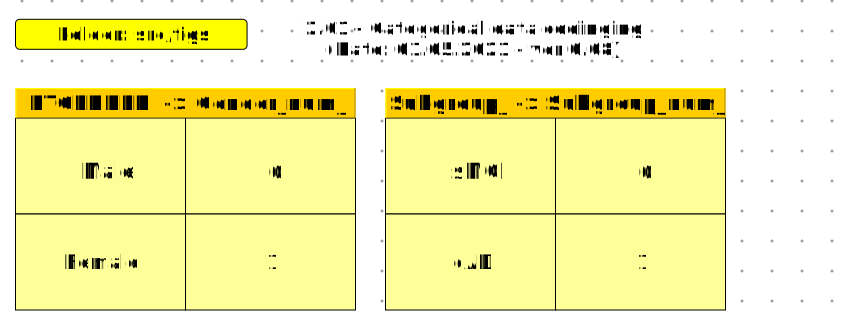

In [28]:
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

___

# PREPARE `CROSS-VALIDATION` FOLDS FOR FUTURES USE (E.G. WITH LONGITUDINAL DATA)

### SAVE `CROSS-VALIDATION` FOLDS TO A `CSV` FILE

To have the same split rules for `bl` and `long` analysies we prepare a csv file with splits between `train` and `test` sets for varius k, e.g. for `k={10,20,50}`.

In [29]:
save_kfolds = 1

if save_kfolds:
    df2 = pd.DataFrame(index=X_train.index)
    #df2['X_train_idx'] = X_train.index
    
    for fld in FOLDS_LIST:
        # prefix: SKF_
        skf = StratifiedKFold(n_splits=fld, shuffle=False)
        SPLITS = []

        # a table for each fold separately (10...20...50)
        df = pd.DataFrame(index=X_train.index)
        
        
        for k, (train_index, validation_index) in enumerate(skf.split(X_train,y_train)):
        #     X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
        #     y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
            SPLITS.append([train_index, validation_index])
            
            col_name = f'SKF_CV{fld}_F{k:0>2}_'
            df.loc[X_train.index[validation_index], col_name] = "val"
            df.loc[X_train.index[train_index], col_name] = "train"
            
        # a table to concatenate tables with folds -> concat([df10, df20, df50])
        df2 = pd.concat([df2,df], axis=1)  
    
    # save to a file
    kfolds_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_kfolds.csv'
    df2.to_csv(kfolds_csv_path)
    print(f'File saved to\n\t{kfolds_csv_path}')
    print()

File saved to
	/Users/ingridrye/123/results/20211111/3.13_K50_RF__kfolds.csv



# **IR PRØVER Å LEGGE INN 50 FOLDS**

#### LOAD `CROSS-VALIDATION` FOLDS FROM FILE

In [30]:
kfolds_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_kfolds.csv'
SPLITS = mutils.load_train_val_cv_splits_from_file(kfolds_csv_path, FOLDS)  

print(f"test\tval.\ttotal\n{25*'-'}")
for k in range(len(SPLITS)):
    #             #train, #val, #sum
    print(f'{len(SPLITS[k][0])}\t{len(SPLITS[k][1])}\t{len(SPLITS[k][0])+len(SPLITS[k][1])}')

test	val.	total
-------------------------
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539


In [31]:
print(type(SPLITS))

<class 'list'>


In [32]:
# print(SPLITS[1])

In [33]:
#Den 
SPLITS[0][1]

array([ 0,  1,  2,  3,  4,  5,  6,  7, 10, 13, 14])

---

# RANDOM FORESTS CLASSIFICATION

___

## REMOVE SELECTED COLUMNS FROM THE TRAIN & TEST SETS

In [34]:
print('From:')
for name, X in X_sets:
    print(f'\t{name}')
    
    for feat in ['Subgroup_', 'Subgroup_num_', 'Usage_', 'PTGENDER']:
        if feat in X.columns: X.drop(columns=feat,inplace=True); print(f'\t\tRemoved: {feat}')

From:
	X train set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: PTGENDER
	X test set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: PTGENDER


In [35]:
print('Column names in:\n')
for name, X in X_sets:
    print(f'- {name}:\n  {X.columns.to_list()}\n')

Column names in:

- X train set:
  ['AGE', 'RAVLT-Im', 'RAVLT-Delay', 'RAVLT-Recog', 'TMTA', 'TMTB', 'CFT', 'GDS', 'ANART', 'HC', 'APOE', 'GENDER']

- X test set:
  ['AGE', 'RAVLT-Im', 'RAVLT-Delay', 'RAVLT-Recog', 'TMTA', 'TMTB', 'CFT', 'GDS', 'ANART', 'HC', 'APOE', 'GENDER']



#### BASIC STATISTISC OF FEATURES IN TRAIN AND TEST SETS

In [36]:
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, X in X_sets:
        print(f'\n{name} (Subjects {X.shape[0]}):')
        display(minfo.df_stats_info(X, precision=2))

Basic statistics for features in both sets:

X train set (Subjects 539):


max.    mean  min.    std  val_range  NaN_Nr
AGE           91.40   73.55  55.2   7.25       36.2       0
RAVLT-Im      67.00   33.13  11.0  10.34       56.0       0
RAVLT-Delay   15.00    3.53   0.0   3.74       15.0       0
RAVLT-Recog   15.00   10.32   0.0   3.49       15.0       0
TMTA         150.00   42.03  13.0  18.35      137.0       0
TMTB         300.00  121.27  33.0  66.95      267.0       0
CFT           35.00   16.82   5.0   5.14       30.0       0
GDS            6.00    1.69   0.0   1.45        6.0       0
ANART         50.00   13.20   0.0   9.44       50.0       0
HC             0.01    0.00   0.0   0.00        0.0       0
APOE           1.00    0.53   0.0   0.50        1.0       0
GENDER         1.00    0.40   0.0   0.49        1.0       0


X test set (Subjects 139):


max.    mean  min.    std  val_range  NaN_Nr
AGE           88.40   73.34  55.0   7.51       33.4       0
RAVLT-Im      65.00   34.01  20.0   8.73       45.0       0
RAVLT-Delay   14.00    3.58   0.0   3.41       14.0       0
RAVLT-Recog   15.00   10.65   1.0   3.43       14.0       0
TMTA         150.00   40.98  16.0  20.45      134.0       0
TMTB         300.00  116.34  38.0  65.94      262.0       0
CFT           30.00   17.10   6.0   4.77       24.0       0
GDS            5.00    1.64   0.0   1.26        5.0       0
ANART         44.00   12.53   0.0   9.62       44.0       0
HC             0.01    0.00   0.0   0.00        0.0       0
APOE           1.00    0.53   0.0   0.50        1.0       0
GENDER         1.00    0.41   0.0   0.49        1.0       0

---

# GRID SEARCH (PERFORM  OR LOAD)

In [37]:
# Run gridsearch (if grid_search=1) and save the model to a file
# Load the best model from the file (if grid_search = 0)
grid_search = 0

# A filename of the the whole gridsearch structure
file_name_prefix_ext = FILE_NAME_WITH_GS_MODEL_TO_LOAD + '-GS-model.pkl'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext

# define a stratification sheme
skf = StratifiedKFold(n_splits=FOLDS, shuffle=False)

if grid_search:       
    print("Searching the best RF's parameters...")
    rfcl = RandomForestClassifier(random_state=RANDOM_STATE)

    params = {"n_estimators": [40, 60, 70, 75, 80, 85, 90, 100, 120, 500, 1000, 10000],
              "max_depth": [3, 4, 5, 6],
              "max_features": [2, 3, 4, 5],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [1, 2, 3],
              "bootstrap": [True, False],
              "criterion": ["gini", 'entropy']}    
    #params = {"n_estimators": [100, 373, 374, 375,1000, 10000]}
    
    grid = GridSearchCV(estimator=rfcl, param_grid=params, verbose=1, refit='accuracy', cv=skf, n_jobs=32, 
                       scoring = ['accuracy', 'f1', 'precision', 'recall'])
    
    # fit the best estimator to the train data
    grid.fit(X_train, y_train)
    
    # save best estimator to the file
    joblib.dump(grid, file_name_prefix_path)     
    print(f'Saved GridSearch object to: {file_name_prefix_path}')
else:
    print(f"GridSearch parameters loaded from a file:\n\t\t{file_name_prefix_path}")
    grid = joblib.load(file_name_prefix_path)     

    
clf = grid.best_estimator_

print()
print(f'Best score: {grid.best_score_:.3f}\n')

print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
    
# save best params to a global variable
print('Best params are stored in BEST_PARAMS variable!!!')
BEST_PARAMS = grid.best_params_


#print(grid.cv_results_)
# for k in metrics.SCORERS.keys():
#     print(k)

GridSearch parameters loaded from a file:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF-master_-GS-model.pkl

Best score: 0.746

Best params:
	bootstrap: True
	criterion: gini
	max_depth: 5
	max_features: 2
	min_samples_leaf: 1
	min_samples_split: 3
	n_estimators: 70
Best params are stored in BEST_PARAMS variable!!!


In [38]:
BEST_PARAMS

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 70}

___

# A PIPELINE WITH ESTABLISHED RF PARAMETERS (AFTER GRID SEARCH) 

---

## CV50 SCORES (F1, ACCURACY, REACALL, PRECISION)

In [41]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
scores_cv = cross_validate(clf, X_train, y_train, cv=SPLITS, scoring=['accuracy', 'f1', 'recall', 'precision'])

scores_cv_df = pd.DataFrame(scores_cv)
scores_cv_df = scores_cv_df[['test_accuracy', 'test_f1', 'test_recall', 'test_precision']]
scores_cv_df.rename(columns = {'test_accuracy': 'acc', 'test_f1':'f1',
                               'test_recall':'recall', 'test_precision':'prec'}, inplace=True)
display(scores_cv_df)

acc        f1    recall      prec
0   0.727273  0.800000  1.000000  0.666667
1   0.727273  0.727273  0.666667  0.800000
2   0.454545  0.500000  0.500000  0.500000
3   0.909091  0.923077  1.000000  0.857143
4   0.727273  0.727273  0.666667  0.800000
5   0.545455  0.545455  0.500000  0.600000
6   0.909091  0.909091  1.000000  0.833333
7   0.636364  0.666667  0.800000  0.571429
8   0.636364  0.714286  1.000000  0.555556
9   0.727273  0.727273  0.800000  0.666667
10  0.454545  0.571429  0.800000  0.444444
11  0.909091  0.909091  1.000000  0.833333
12  0.727273  0.769231  1.000000  0.625000
13  0.909091  0.909091  1.000000  0.833333
14  0.909091  0.909091  1.000000  0.833333
15  0.909091  0.909091  1.000000  0.833333
16  0.545455  0.615385  0.800000  0.500000
17  0.545455  0.615385  0.800000  0.500000
18  0.909091  0.888889  0.800000  1.000000
19  0.909091  0.909091  1.000000  0.833333
20  1.000000  1.000000  1.000000  1.000000
21  1.000000  1.000000  1.000000  1.000000
22  0.818182  0.750000  0.600000  1.000000
23  0.818182  0.800000  0.800000  0.800000
24  0.909091  0.888889  0.800000  1.000000
25  0.909091  0.888889  0.800000  1.000000
26  0.636364  0.600000  0.600000  0.600000
27  0.727273  0.769231  1.000000  0.625000
28  0.909091  0.909091  1.000000  0.833333
29  0.909091  0.909091  1.000000  0.833333
30  0.818182  0.750000  0.600000  1.000000
31  0.363636  0.000000  0.000000  0.000000
32  0.818182  0.800000  0.800000  0.800000
33  0.545455  0.545455  0.600000  0.500000
34  0.727273  0.571429  0.400000  1.000000
35  0.909091  0.909091  1.000000  0.833333
36  0.818182  0.833333  1.000000  0.714286
37  0.818182  0.800000  0.800000  0.800000
38  0.818182  0.800000  0.800000  0.800000
39  0.700000  0.571429  0.400000  1.000000
40  0.800000  0.800000  0.800000  0.800000
41  0.900000  0.909091  1.000000  0.833333
42  0.600000  0.600000  0.600000  0.600000
43  0.600000  0.500000  0.400000  0.666667
44  0.800000  0.800000  0.800000  0.800000
45  0.800000  0.800000  0.800000  0.800000
46  0.500000  0.615385  0.800000  0.500000
47  0.600000  0.666667  0.800000  0.571429
48  0.500000  0.545455  0.600000  0.500000
49  0.500000  0.444444  0.400000  0.500000

### Mean score values for crossvalidation (k=50 folds):

In [42]:
prec = 2
score_all_folds_mean_df = pd.DataFrame.from_dict({'mean':scores_cv_df.mean().round(prec+2),
                                                  'std.':scores_cv_df.std().round(prec+1),
                                                  'min.':scores_cv_df.min().round(prec+2),
                                                  'max.':scores_cv_df.max().round(prec+2),
                                                  'range':scores_cv_df.values.ptp(axis=0).round(prec)})
display(score_all_folds_mean_df)

mean   std.    min.  max.  range
acc     0.7460  0.163  0.3636   1.0   0.64
f1      0.7405  0.181  0.0000   1.0   1.00
recall  0.7827  0.223  0.0000   1.0   1.00
prec    0.7360  0.201  0.0000   1.0   1.00

----

In [43]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)


feat_import_CV = pd.DataFrame(index=X_train.columns, columns=list(range(FOLDS)))
conf_matrix_CV = np.zeros((FOLDS, 2 ,2))
valid_set_len_CV = np.ones(FOLDS)  # to calculate mean validation test lenght
bl_CV_pred_all = pd.DataFrame()


for k, (train_index, validation_index) in enumerate(SPLITS):
    X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
    y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
      
    # MODEL    
    # fit
    clf.fit(X_trainCV, y_trainCV)
    # predict
    y_predCV= clf.predict(X_validCV).reshape(-1,)
    
    # METRICS
    # confusion matrix for all folds
    conf_matrix_CV[k, :, :]  = metrics.confusion_matrix(y_validCV, y_predCV)    
    # feature importance for all folds
    feat_import_CV[k] = clf.feature_importances_
    
    # CONFUSION MATRIX coefficients
    X_validCV_extended = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_validCV, y_validCV, y_predCV)
    
    # additional info about the current fold
    X_validCV_extended[f'CV{FOLDS}F_'] = k
    X_validCV_extended[f'CV{FOLDS}_Usage_'] = 'valid' 
    
    # df to agregate confusion-matrix-coefficients from all folds
    bl_CV_pred_all = pd.concat([bl_CV_pred_all, X_validCV_extended], axis=0)     
    
    # df with MISCLASSIFIED subjects in the current fold (k)
    err = X_validCV_extended.loc[(X_validCV_extended.y_true_ != X_validCV_extended.y_pred_)]
    print(f'fold: {k}, errors: {err.shape[0]}/{y_validCV.shape[0]}  ({err.shape[0]/y_validCV.shape[0]*100 :.1f}%)')
       
    # set current validation test set length
    valid_set_len_CV[k] = len(y_validCV)

fold: 0, errors: 3/11  (27.3%)
fold: 1, errors: 3/11  (27.3%)
fold: 2, errors: 6/11  (54.5%)
fold: 3, errors: 1/11  (9.1%)
fold: 4, errors: 3/11  (27.3%)
fold: 5, errors: 5/11  (45.5%)
fold: 6, errors: 1/11  (9.1%)
fold: 7, errors: 4/11  (36.4%)
fold: 8, errors: 4/11  (36.4%)
fold: 9, errors: 3/11  (27.3%)
fold: 10, errors: 6/11  (54.5%)
fold: 11, errors: 1/11  (9.1%)
fold: 12, errors: 3/11  (27.3%)
fold: 13, errors: 1/11  (9.1%)
fold: 14, errors: 1/11  (9.1%)
fold: 15, errors: 1/11  (9.1%)
fold: 16, errors: 5/11  (45.5%)
fold: 17, errors: 5/11  (45.5%)
fold: 18, errors: 1/11  (9.1%)
fold: 19, errors: 1/11  (9.1%)
fold: 20, errors: 0/11  (0.0%)
fold: 21, errors: 0/11  (0.0%)
fold: 22, errors: 2/11  (18.2%)
fold: 23, errors: 2/11  (18.2%)
fold: 24, errors: 1/11  (9.1%)
fold: 25, errors: 1/11  (9.1%)
fold: 26, errors: 4/11  (36.4%)
fold: 27, errors: 3/11  (27.3%)
fold: 28, errors: 1/11  (9.1%)
fold: 29, errors: 1/11  (9.1%)
fold: 30, errors: 2/11  (18.2%)
fold: 31, errors: 7/11  (63.6%)


In [44]:
#df_predictions_all.tail(3)

#### LINK PREDICTION TABLE WITH OTHER SUBJECT FEATURES

The predictions and all other subject features are stored in a `csv` file.

In [45]:
cols2 =[f'CV{FOLDS}F_',  f'CV{FOLDS}_Usage_'] 
filename = FILE_NAME_PREFIX + f'-CV{FOLDS}-predictions.csv'

bl_CV_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_CV_pred_all, cols2,
                                                                            filename, save=True, results_dir=RESULTS_DIR)


Subjects in the predictions table: 539

Predictions have been saved to a file:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-CV50-predictions.csv


#### INTERACTIVE FOLDS INVESTIGATION (OPTIONAL)

In [46]:
if VERBOSE:
    cols = ['RID',  'y_true_', 'y_pred_', 'CM_pred_', f'CV{FOLDS}F_']
    minfo.iterate_patient_GUI(bl_CV_pred_full[cols], column=f'CV{FOLDS}F_')

---

# MODEL ANALYSIS & VISUALIZATION

---

## FEATURE IMPORTANCE (AVERAGE OUT OF 10 FOLDS)

In [47]:
feat_import_CV.reset_index(inplace=True)
feat_import_CV = feat_import_CV.rename({'index': 'feature'}, axis='columns')

#### FATURE IMPORTANCE IN EACH FOLD

In [48]:
if VERBOSE:
    display(feat_import_CV)

feature         0         1         2         3         4         5  \
0           AGE  0.064303  0.068183  0.057930  0.062102  0.060319  0.060508   
1      RAVLT-Im  0.210235  0.209178  0.201316  0.203161  0.212750  0.209772   
2   RAVLT-Delay  0.157467  0.161950  0.172076  0.160498  0.166956  0.164028   
3   RAVLT-Recog  0.072023  0.061461  0.056333  0.060574  0.062263  0.063640   
4          TMTA  0.056260  0.054777  0.055799  0.057222  0.045650  0.049543   
5          TMTB  0.074826  0.074411  0.074403  0.077675  0.075957  0.075313   
6           CFT  0.052735  0.056923  0.062453  0.056180  0.060062  0.050966   
7           GDS  0.027862  0.027506  0.028191  0.029244  0.023863  0.025483   
8         ANART  0.042021  0.045456  0.046852  0.042263  0.047234  0.047315   
9            HC  0.188073  0.190115  0.195726  0.200090  0.188609  0.200071   
10         APOE  0.042313  0.034126  0.032761  0.035797  0.040996  0.038847   
11       GENDER  0.011883  0.015914  0.016162  0.015197  0.015342  0.014514   

           6         7         8  ...        40        41        42        43  \
0   0.071751  0.057692  0.065159  ...  0.068253  0.067463  0.067791  0.057479   
1   0.200184  0.183152  0.200163  ...  0.200216  0.209939  0.197414  0.211465   
2   0.169454  0.179394  0.171044  ...  0.163856  0.152787  0.171302  0.154524   
3   0.070092  0.069659  0.059235  ...  0.061098  0.074376  0.064988  0.073590   
4   0.051316  0.066606  0.055021  ...  0.047906  0.048948  0.047926  0.048016   
5   0.078981  0.080533  0.087011  ...  0.073352  0.069397  0.069958  0.077211   
6   0.048668  0.051307  0.060144  ...  0.049953  0.054153  0.048180  0.054181   
7   0.019208  0.024626  0.021915  ...  0.024005  0.027952  0.024226  0.023746   
8   0.051468  0.046258  0.043075  ...  0.054062  0.051560  0.052163  0.049851   
9   0.182461  0.183939  0.177478  ...  0.203306  0.188033  0.196514  0.197744   
10  0.040935  0.042458  0.045711  ...  0.040319  0.039273  0.044635  0.037376   
11  0.015483  0.014375  0.014045  ...  0.013673  0.016120  0.014903  0.014816   

          44        45        46        47        48        49  
0   0.061372  0.067907  0.067422  0.062185  0.062053  0.060012  
1   0.202102  0.188732  0.190542  0.182262  0.190909  0.187325  
2   0.159943  0.169715  0.164434  0.189510  0.162438  0.167420  
3   0.069789  0.063198  0.065135  0.069867  0.071777  0.066069  
4   0.053246  0.051923  0.050549  0.051076  0.054609  0.054749  
5   0.081375  0.074500  0.073408  0.075844  0.081661  0.080056  
6   0.048296  0.047320  0.051379  0.047111  0.050291  0.043536  
7   0.023062  0.021696  0.019617  0.021468  0.021760  0.018768  
8   0.051456  0.049746  0.051362  0.053890  0.050483  0.054452  
9   0.195654  0.203044  0.201644  0.189193  0.204859  0.217873  
10  0.039163  0.048249  0.050268  0.043878  0.035645  0.034051  
11  0.014542  0.013970  0.014239  0.013716  0.013516  0.015689  

[12 rows x 51 columns]

#### AVERAGE FEATURE IMPORTANCE OVER 10 FOLDS

In [49]:
feat_import_CV_stats = pd.DataFrame.from_dict({'feature':feat_import_CV.feature, 'mean':feat_import_CV.mean(axis=1).round(2), 'std.':feat_import_CV.std(axis=1).round(2)})
feat_import_CV_stats.sort_values(by='mean',ascending=False)

feature  mean  std.
1      RAVLT-Im  0.20  0.01
9            HC  0.19  0.01
2   RAVLT-Delay  0.17  0.01
5          TMTB  0.08  0.00
3   RAVLT-Recog  0.07  0.00
0           AGE  0.06  0.00
4          TMTA  0.06  0.00
6           CFT  0.05  0.00
8         ANART  0.05  0.00
10         APOE  0.04  0.00
7           GDS  0.02  0.00
11       GENDER  0.01  0.00

#### PLOT MEAN FEATURE IMPORTANCE FOR 10 FOLDS (OPTIONAL: SAVE, SIZE, ORIENTATION, ...)

Mean featue importacne plot saved to:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-CV50-feat-importance-h.png



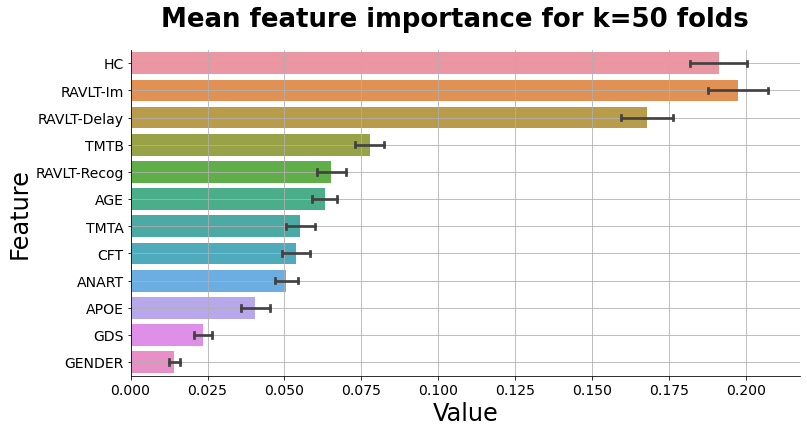

Mean featue importacne plot saved to:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-CV50-feat-importance-v.png



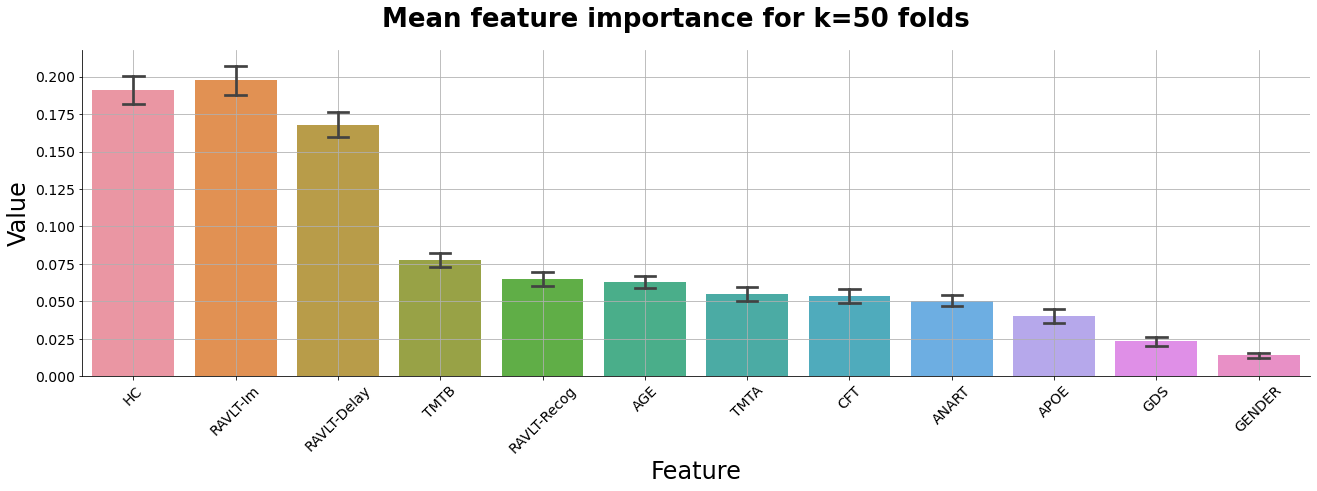

In [50]:
mrfbl.plot_mean_feature_importnce_cv(feat_import_CV, file_name_prefix=FILE_NAME_PREFIX,
                                     orientation='h',folds=FOLDS,figsize=(12,6), results_dir=RESULTS_DIR, save=True)

mrfbl.plot_mean_feature_importnce_cv(feat_import_CV, file_name_prefix=FILE_NAME_PREFIX,
                                     orientation='v', folds=FOLDS, figsize=(22,6), results_dir=RESULTS_DIR, save=True)

---

## CONFUSION MATRIX

#### NUMBER OF SUBJECTS IN EACH FOLD

In [51]:
if VERBOSE:
    print(f'Subjects in each fold:\n\t{valid_set_len_CV}\n')
    print(f'Meand fold length: {valid_set_len_CV.mean()}')

Subjects in each fold:
	[11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]

Meand fold length: 10.78


#### PLOT CONFUSION MATRIX

Confusion matrix saved to:

		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-conf-matrix-CV50.png



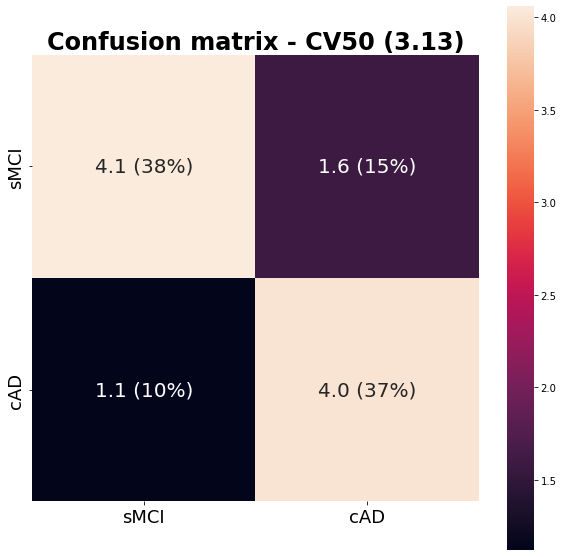

In [52]:
# mean of confusion matix over k=10 folds
conf_mat_mean = conf_matrix_CV.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_mat_mean_prc = conf_mat_mean / valid_set_len_CV.mean() * 100

mrfbl.plot_confusion_matrix_CV(conf_mat_mean, conf_mat_mean_prc, folds=FOLDS, file_name_number=FILE_NAME_NUMBER,
                                file_name_prefix=FILE_NAME_PREFIX, result_dir=RESULTS_DIR, save=True)

---

## CORELATION (OPTIONAL)

In [53]:
# cor = X_train.corr().abs()
# cor2 = np.tril(cor2,  k=0)

# cor2 = pd.DataFrame(np.where(cor2>0.4, cor, 0), columns=X_train.columns)
# cor2.set_index(X_train.columns, inplace=True)

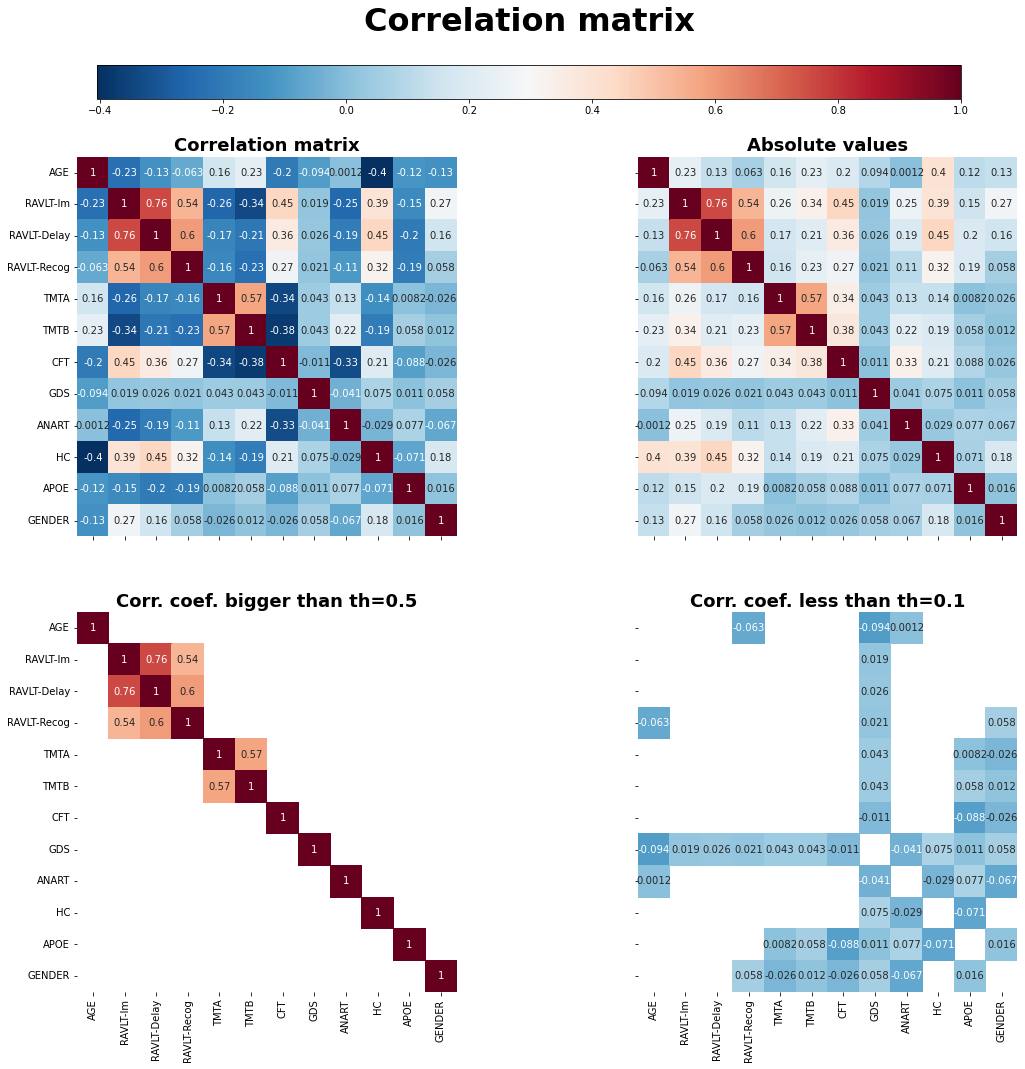

In [54]:
if VERBOSE:
    cor = X_train.corr()
    mn, mx = cor.values.min(), cor.values.max()
    cor_abs = X_train.corr().abs()    
    th1, th2 = 0.5, 0.1
    cor_th1 = cor[cor_abs>th1]
    cor_th2 = cor[cor_abs<th2]
    
    
    
    f,ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(20,16))
    sns.heatmap(cor, annot=True, cmap='RdBu_r', ax=ax[0,0], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_abs, annot=True, cmap='RdBu_r', ax=ax[0,1], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_th1, annot=True, cmap='RdBu_r', ax=ax[1,0], vmin=mn, vmax=mx, cbar=False)    
    sns.heatmap(cor_th2, annot=True, cmap='RdBu_r', ax=ax[1,1], vmin=mn, vmax=mx, cbar=False) 
    
    titles = ['Correlation matrix', 'Absolute values', f'Corr. coef. bigger than th={th1}', f'Corr. coef. less than th={th2}']
    for i,a in enumerate(ax.flat[:]):        
        a.set_aspect(aspect=1)
        a.set_title(titles[i], fontsize=18, fontweight='bold')
    
    
    cax = f.add_axes([0.2, 0.90, 0.6, 0.03])
    norm = plt.Normalize(mn, mx)
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])
    f.colorbar(sm, cax=cax, orientation='horizontal')

    plt.suptitle('Correlation matrix', fontsize=32, fontweight='bold')
    plt.subplots_adjust(wspace=0.01, top=0.85)
    #plt.tight_layout(rect=[0,0,1,0.85])

---

## VISUALIZATION (OPTIONAL)

In [55]:
# if VERBOSE:
#     #https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
#     # Extract single tree
#     estimator = clf.estimators_[4]

#     from sklearn.tree import export_graphviz
#     # Export as dot file
#     export_graphviz(estimator, out_file='tree.dot', 
#                     feature_names = X_train.columns,
#                     class_names = ['sMCi','cAD'],
#                     rounded = True, proportion = False, 
#                     precision = 2, filled = True)

#     # Convert to png using system command (requires Graphviz)
#     from subprocess import call
#     filename1 = FILE_NAME_PREFIX + '-tree.png'
#     filename2 = FILE_NAME_PREFIX + '-tree.pdf'

#     filepath1 = RESULTS_DIR/filename1
#     filepath2 = RESULTS_DIR/filename2

#     call(['dot', '-Tpng', 'tree.dot', '-o', filepath1, '-Gdpi=300'])
#     call(['dot', '-Tpdf', 'tree.dot', '-o', filepath2, '-Gdpi=600'])

#     # Display in jupyter notebook
#     display(Image(filename=filepath1))

#### REMOVE TEMPORARY `tree.png` and `tree.dot` FILES FROM THE CURRENT FOLDER

In [56]:
if 1:
    [f.unlink() for f in list(Path('.').glob("tree.*"))]

---

# TEST SET

---

#### TEST SETS VISUAL INSPECTIONS (OPTIONAL)

In [57]:
if VERBOSE:    
    tmp_df = pd.DataFrame.from_dict({'X_test_mean':X_test.mean().round(2), 'X_test_std':X_test.std().round(2)})
    
    print('"Original" Test set ')
    display(X_test.head())
    print('\nMean and std comparison')
    display(tmp_df)

"Original" Test set 


AGE  RAVLT-Im  RAVLT-Delay  RAVLT-Recog   TMTA   TMTB   CFT  GDS  ANART  \
6    80.4      30.0          1.0          7.0   49.0  168.0  13.0  0.0   17.0   
82   77.3      29.0          0.0         11.0  122.0  151.0  17.0  2.0    3.0   
184  77.5      35.0          1.0         10.0   27.0   69.0  24.0  2.0   22.0   
359  71.1      24.0          0.0          2.0   50.0   85.0  13.0  2.0    7.0   
384  83.6      30.0          2.0          9.0   22.0   76.0  18.0  0.0    9.0   

           HC  APOE  GENDER  
6    0.003638   0.0       1  
82   0.003343   1.0       0  
184  0.003149   1.0       1  
359  0.003729   0.0       1  
384  0.003700   0.0       1


Mean and std comparison


X_test_mean  X_test_std
AGE                73.34        7.51
RAVLT-Im           34.01        8.73
RAVLT-Delay         3.58        3.41
RAVLT-Recog        10.65        3.43
TMTA               40.98       20.45
TMTB              116.34       65.94
CFT                17.10        4.77
GDS                 1.64        1.26
ANART              12.53        9.62
HC                  0.00        0.00
APOE                0.53        0.50
GENDER              0.41        0.49

---

## TRAIN THE RF CLASSIFIER AND PREDICT SUBGROPUS WITH THE USE OF UNSEEN TEST SET

In [58]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

#compare two ways of accuracy calucation
if VERBOSE:
    print(metrics.accuracy_score(y_test, y_test_pred).round(3))
    print(clf.score(X_test, y_test).round(3))

0.662
0.662


## TEST SET SCORES (F1, ACCURACY, RECALL, PRECISION)

In [59]:
# metrics
f1 = metrics.f1_score(y_test, y_test_pred)
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)

print(f'F1: {f1:.3f}')
print(f'ACC: {acc:.3f}')
print(f'RECALL: {recall:.3f}')
print(f'PREC: {prec:.3f}')

F1: 0.630
ACC: 0.662
RECALL: 0.615
PREC: 0.645


## CONUSIOM MATRIX

#### PREDICTIONS

In [60]:
bl_test_pred = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_test, y_test, y_test_pred)

cols2= []
filename = FILE_NAME_PREFIX + f'-TEST-predictions.csv'
bl_test_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_test_pred, cols2, filename,
                                                                              save=True, results_dir=RESULTS_DIR)


Subjects in the predictions table: 139

Predictions have been saved to a file:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-TEST-predictions.csv


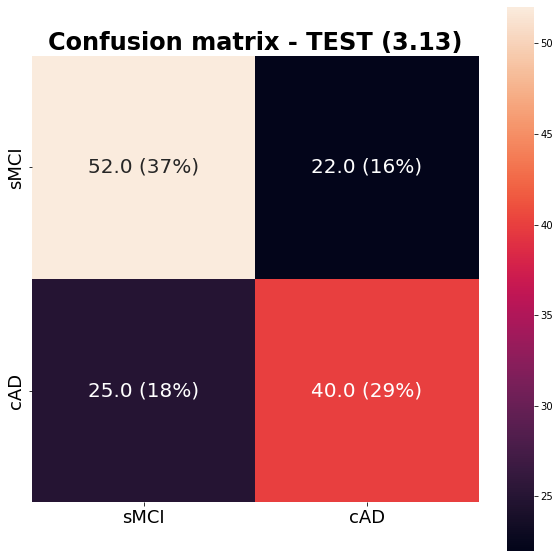

In [61]:
conf_matrix_test  = metrics.confusion_matrix(y_test, y_test_pred)    

# mean of test confusion matix
conf_mat_mean = conf_matrix_test.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100


mrfbl.plot_confusion_matrix_TEST(conf_matrix_test, conf_matrix_test_prc, file_name_number=FILE_NAME_NUMBER, file_name_prefix=FILE_NAME_PREFIX,
                                 save=True, results_dir=RESULTS_DIR)

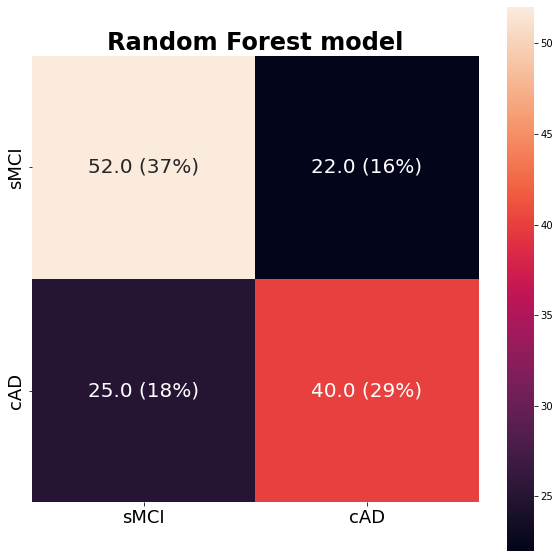

In [62]:
conf_matrix_test  = metrics.confusion_matrix(y_test, y_test_pred)    

# mean of test confusion matix
conf_mat_mean = conf_matrix_test.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100


mrfbl.plot_confusion_matrix_TEST_IR(conf_matrix_test, conf_matrix_test_prc, file_name_number="K50"+FILE_NAME_NUMBER, title = "Random Forest model", file_name_prefix=FILE_NAME_PREFIX,
                                 save=True, results_dir=RESULTS_DIR)

## FEATURE IMPORTANCE

In [63]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print(f'Feature importance for the train set:\n\n{feature_imp.to_string()}')

Feature importance for the train set:

HC             0.208739
RAVLT-Im       0.187059
RAVLT-Delay    0.162150
TMTB           0.078708
RAVLT-Recog    0.075343
AGE            0.066962
TMTA           0.052947
ANART          0.050707
CFT            0.047168
APOE           0.036140
GDS            0.018221
GENDER         0.015856


Mean featue importacne plot saved to:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-TEST-feat-importance-h.png



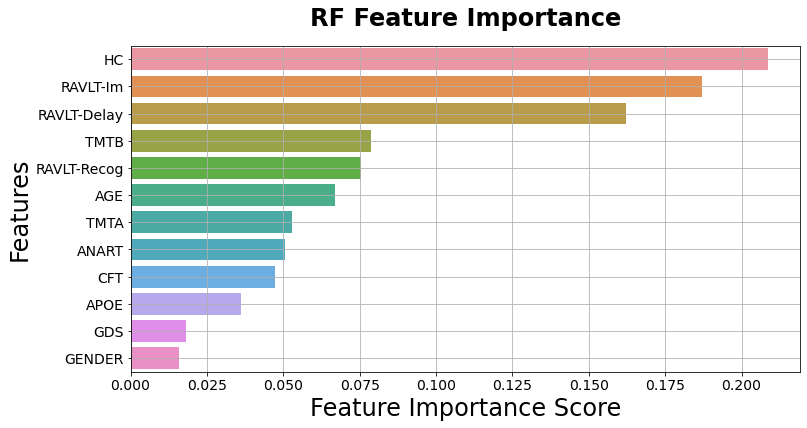

Mean featue importacne plot saved to:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-TEST-feat-importance-v.png



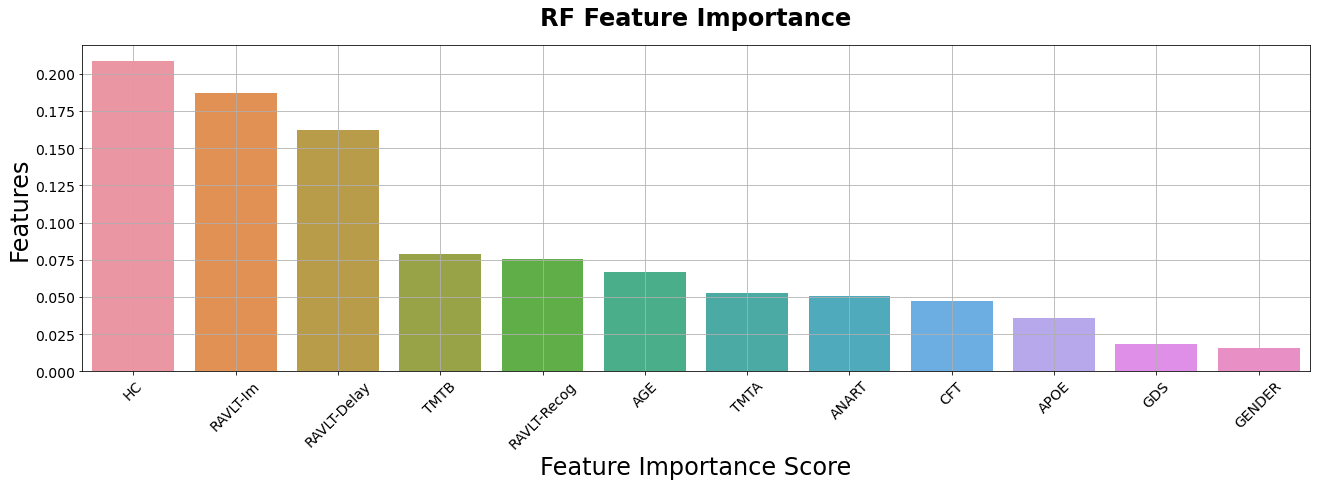

In [65]:
mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='h', figsize=(12,6), results_dir = RESULTS_DIR)

mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='v', figsize=(22,6), results_dir = RESULTS_DIR)

# Slice datafilen 

In [66]:
# This is to save the four dataframes with the excact subjects used in this model
X_test.to_csv(RESULTS_DIR / '3.13_X_test.csv')
X_train.to_csv(RESULTS_DIR / '3.13_X_train.csv')
y_test.to_csv(RESULTS_DIR / '3.13_y_test.csv')
y_train.to_csv(RESULTS_DIR / '3.13_y_train.csv')

Xy_train = pd.concat([X_train, y_train], axis=1).reindex(X_train.index)
Xy_train.to_csv(RESULTS_DIR / '3.13_Xy_train.csv')

Xy_test = pd.concat([X_test, y_test], axis=1).reindex(X_test.index)
Xy_test.to_csv(RESULTS_DIR / '3.13_Xy_test.csv')

# For hele datafilen brukt i analyse (altsaa samme som BL, but without subjects who had missing values)
Xy_train_test = frames = [Xy_train, Xy_test] 
Xy_train_test = pd.concat(frames)

Xy_train_test.to_csv(RESULTS_DIR / '3.13_Xy_test_train.csv')

# Slice datafilen 2 
This is to concatinate the two prediction tables created above to get a dataframe containing:
1. all features from main script with only  
2. extra column containing information about prediction (i.e. TN,FP, FN, TP) 

In [67]:
# Load prediction-files for CV k=50 
prediction_train = pd.read_csv ('../results/20211111/3.13_K50_RF_-CV50-predictions.csv')
prediction_train.shape

(539, 140)

In [68]:
# Load prediction-files for TEST 
prediction_test = pd.read_csv ('../results/20211111/3.13_K50_RF_-TEST-predictions.csv')
prediction_test.shape

(139, 138)

In [69]:
# Concatinate these the two prediction tables created above to create a dataframe containing:
# 1. all features from main script with only  
# 2. extra column containing information about prediction (i.e. TN,FP, FN, TP) 

prediction_full = pd.concat([prediction_train, prediction_test])
prediction_full.shape
prediction_full.to_csv(RESULTS_DIR / '3.13_FULL-prediction.csv')

---

# FEATURE PERMUTATION WITH `eli5` 
([www](https://eli5.readthedocs.io/en/latest/overview.html))

In [70]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_split=3,
                       n_estimators=70, random_state=42)

#### TRAIN SET

In [71]:
# perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_train, y_train)
# eli5.show_weights(perm, feature_names = X_train.columns.tolist())

## TEST SET

In [72]:
perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(),)

---

# PARTIAL DEPENDENCE PLOTS

#### 1D PDPs

In [185]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_split=3,
                       n_estimators=70, random_state=42)

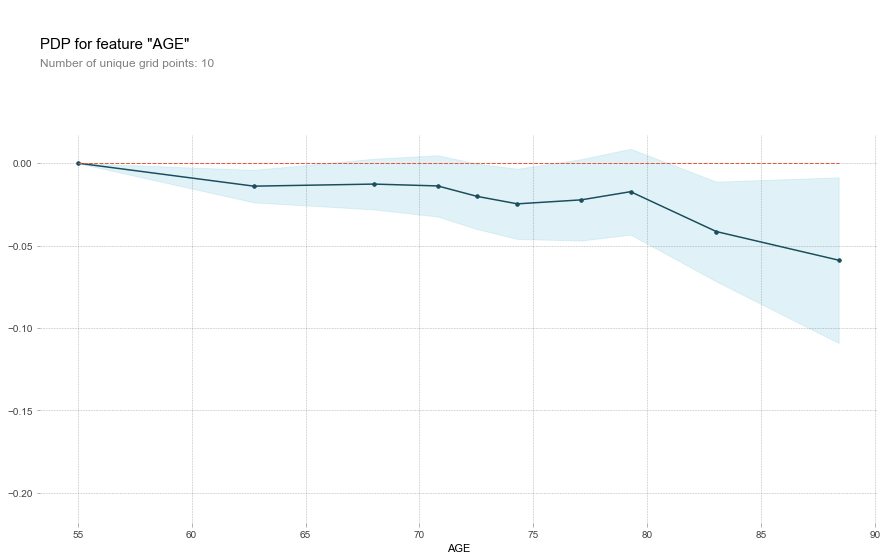

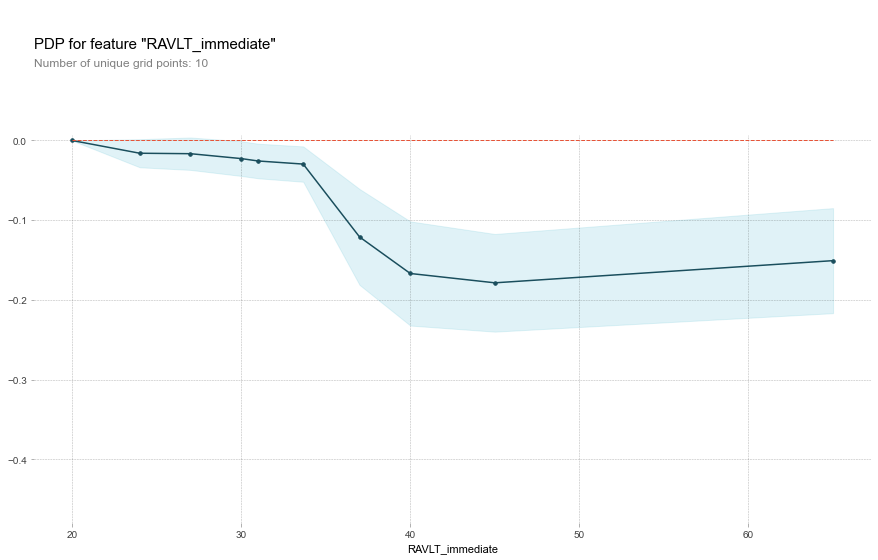

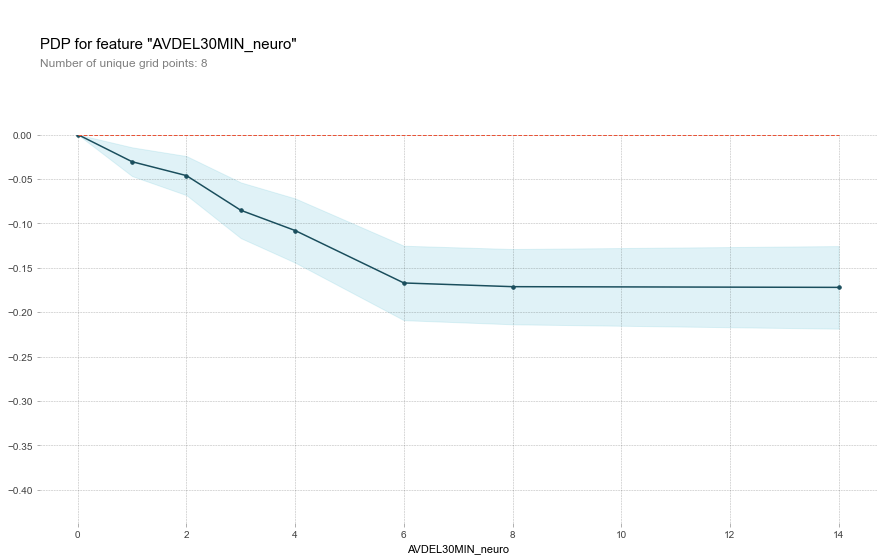

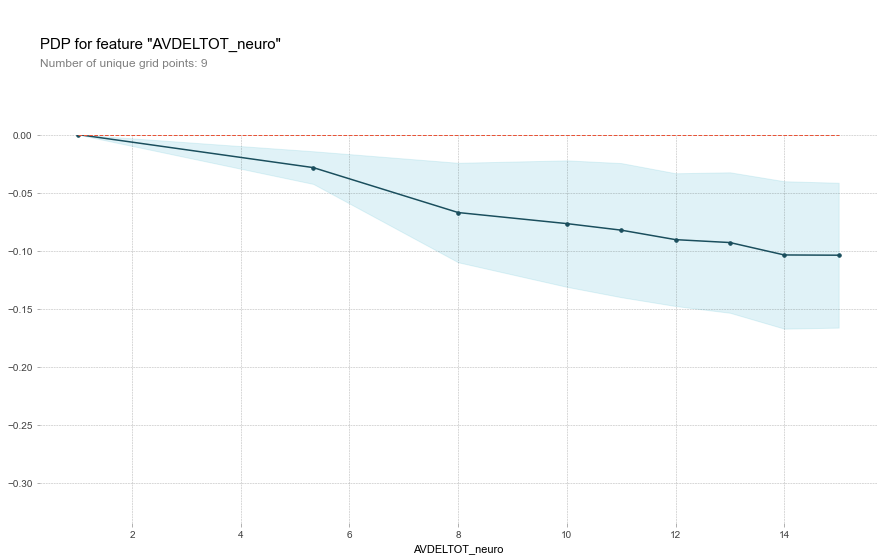

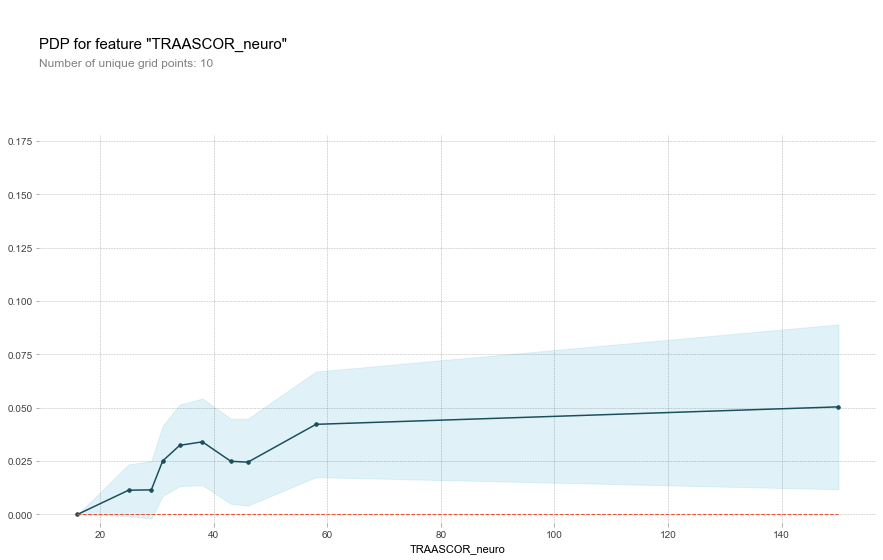

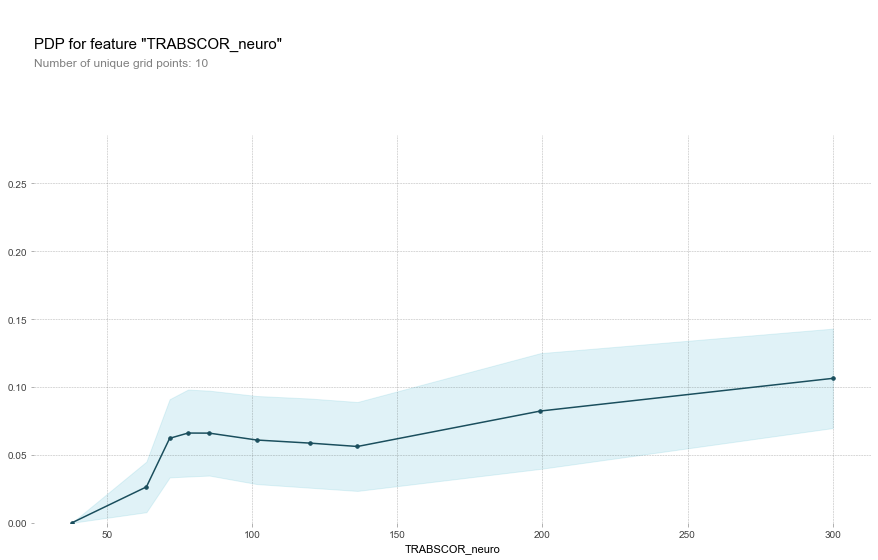

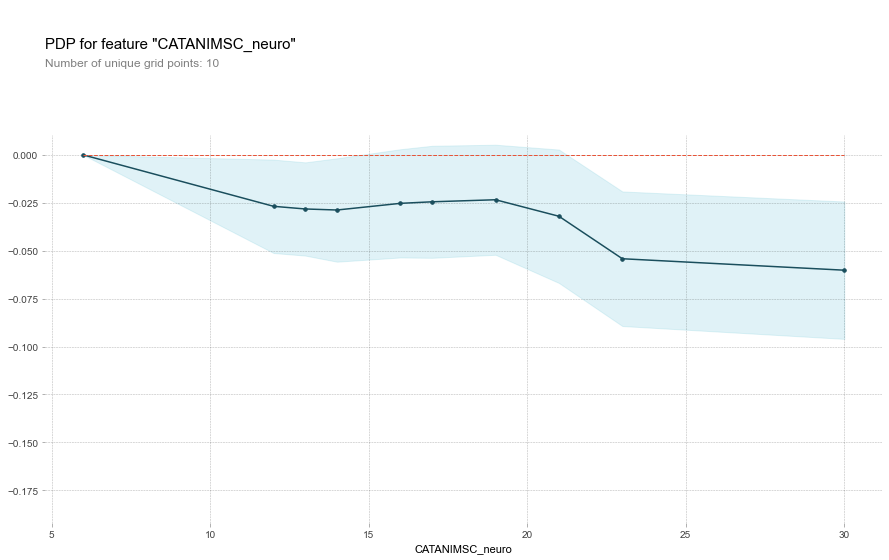

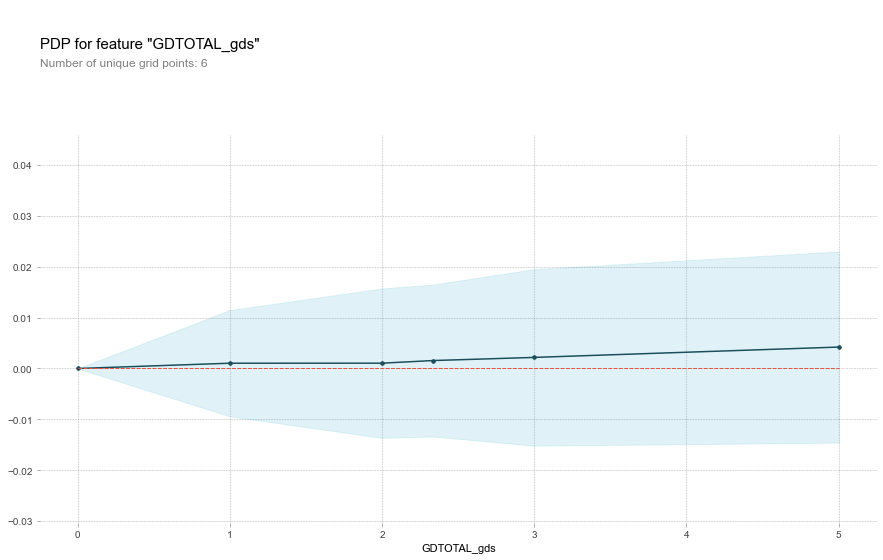

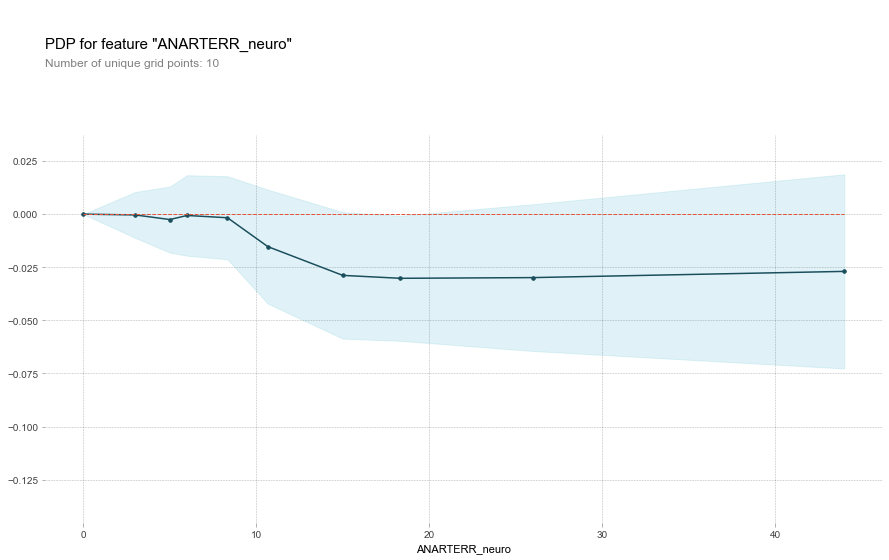

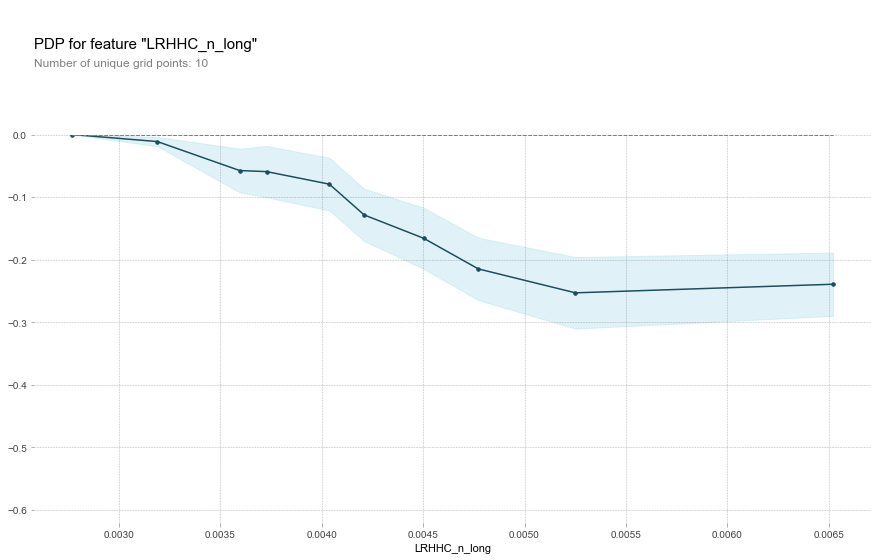

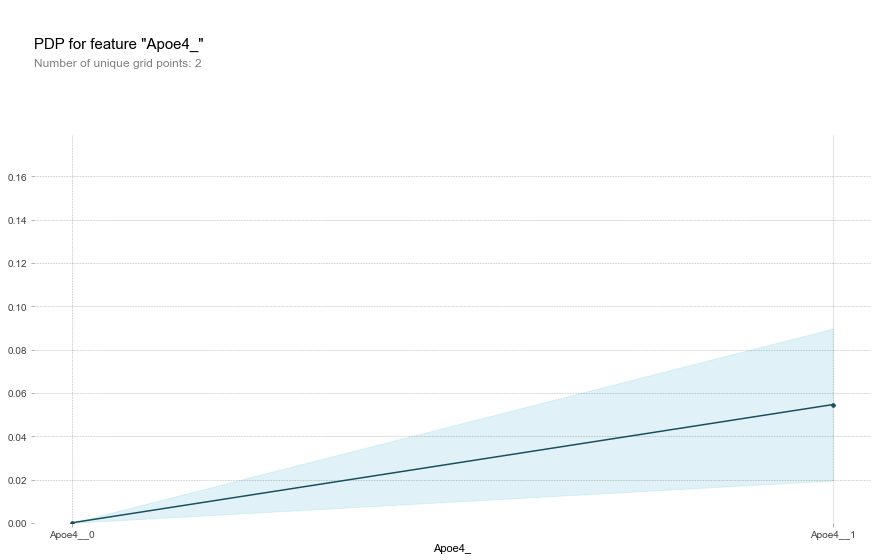

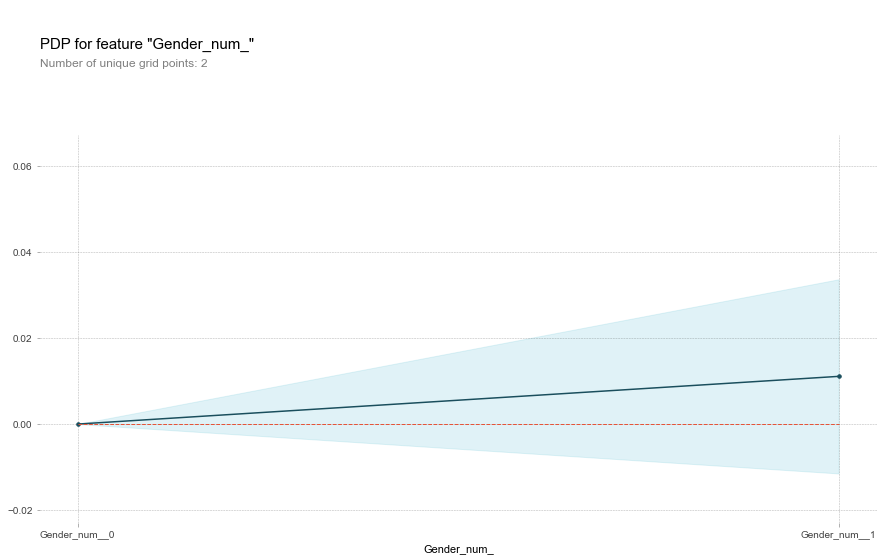

In [186]:
for feature in X_test.columns:
    pdp_goals = pdp.pdp_isolate(model=clf, dataset=X_test, model_features=X_test.columns.tolist(),
                                feature=feature)    
    pdp.pdp_plot(pdp_goals, feature)

    file_name_prefix_ext = f'{FILE_NAME_PREFIX}-pdp-TEST-{feature}.png'
    file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
    plt.savefig(file_name_prefix_path)

    plt.show()

#### 2D PDPs

In [187]:
# feat = ['LRHHC_n_long', 'AVDEL30MIN_neuro']
# interact  =  pdp.pdp_interact(model=clf, dataset=X_test, model_features=X_test.columns.tolist(), features=feat)
# pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=feat, plot_type='contour')
# plt.show()

In [188]:
# feat = ['LRHHC_n_long', 'AVDEL30MIN_neuro']
# interact  =  pdp.pdp_interact(model=clf, dataset=X_test, model_features=X_test.columns.tolist(), features=feat)
# pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=feat, plot_type='grid')
# plt.show()

---

# 3D partial dependence plots

Code copied from https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py

Changed features and titles obviously, but also 'est' to 'clf'

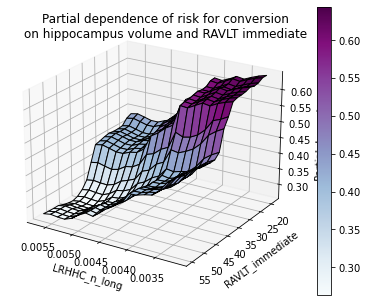

In [189]:
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features = ("LRHHC_n_long", "RAVLT_immediate")
pdp = partial_dependence(
    clf, X_train, features=features, kind="average", grid_resolution=20
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of risk for conversion\n"
    "on hippocampus volume and RAVLT immediate"
)
plt.subplots_adjust(top=0.9)
plt.show()

---

# PDP AND ICE PLOTS WITH SCIKIT-LEARN ([www](https://scikit-learn.org/stable/modules/partial_dependence.html))

In [190]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_split=3,
                       n_estimators=70, random_state=42)

In [191]:
print(FEATURES)

['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Subgroup_', 'Subgroup_num_', 'Usage_', 'PTGENDER', 'Gender_num_']


#### PARTIAL DEPENDENCE PLOTS

#### INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS - TRAIN SET

In [192]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_split=3,
                       n_estimators=70, random_state=42)

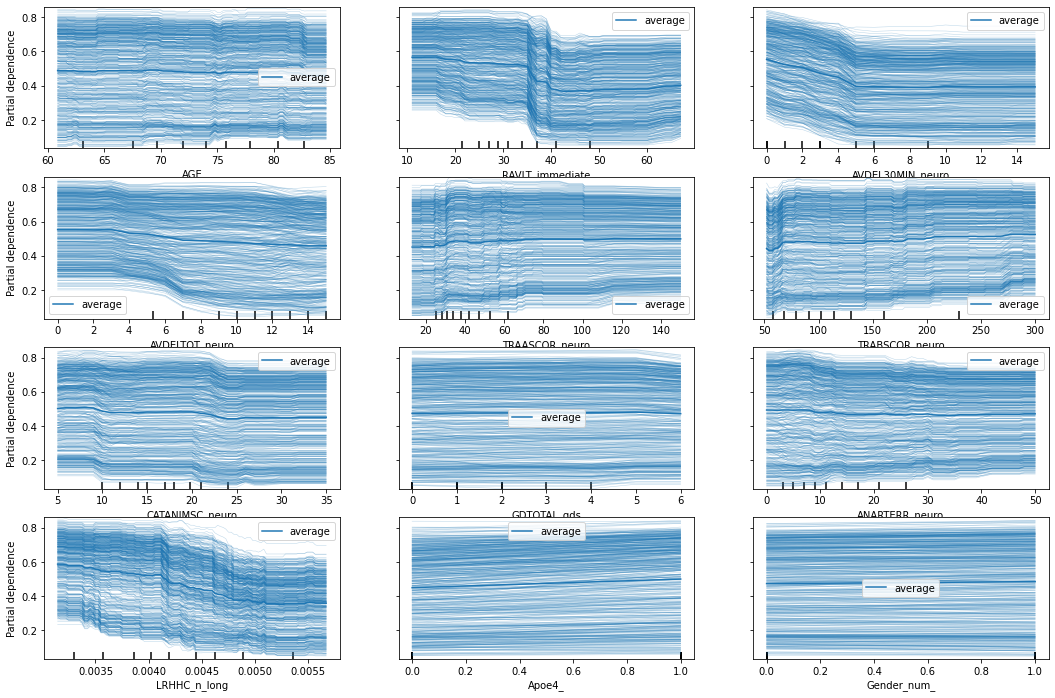

In [193]:
fig,ax = plt.subplots(figsize=(18,12),)
_=plot_partial_dependence(clf, X_train, features=X_train.columns, kind='both', ax=ax)

#### INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS - TEST SET

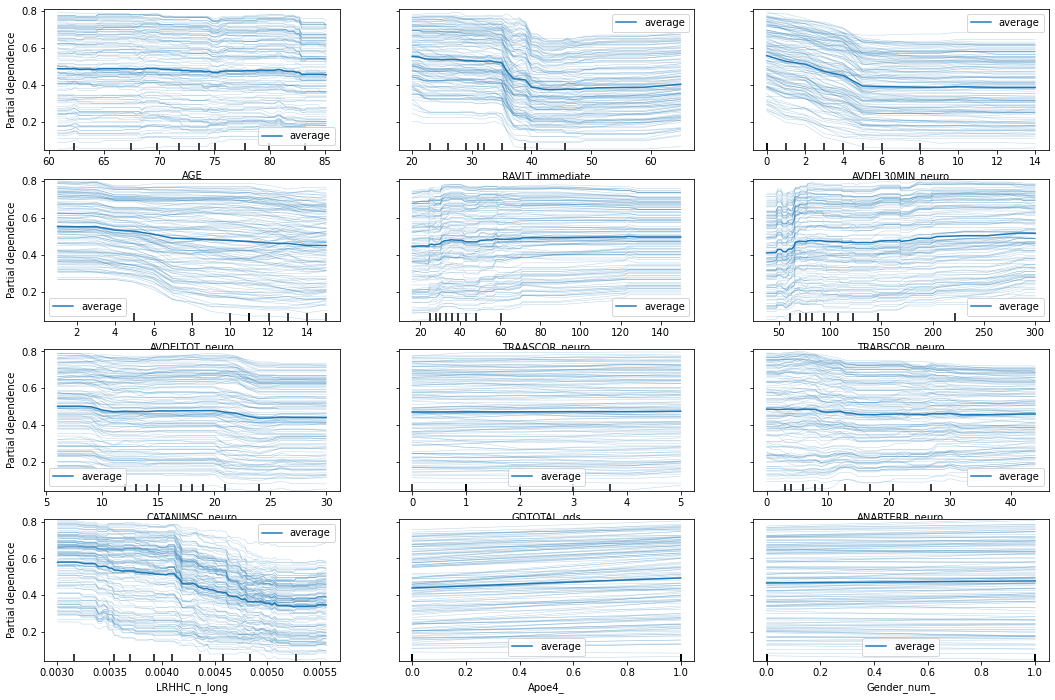

In [194]:
fig,ax = plt.subplots(figsize=(18,12))
_=plot_partial_dependence(clf, X_test, features=X_test.columns, kind='both', ax=ax)

In [195]:
dataSET = pd.read_csv('../Ingrid/pycaret_K50/RF_K50_final_df_best_blended_top5_K50.csv', index_col=0)
dataSET.shape

(139, 141)

## ICE PLOTS for True Negative

In [196]:
# Only TN 
TNx = dataSET.loc[dataSET.CM_pred_ == 'TN']
TNx.shape

(52, 141)

In [227]:
sMCIxxx = dataSET.loc[dataSET.Subgroup_ == 'sMCI']
sMCIxxx.shape

(74, 141)

ValueError: could not convert string to float: '100_S_0006'

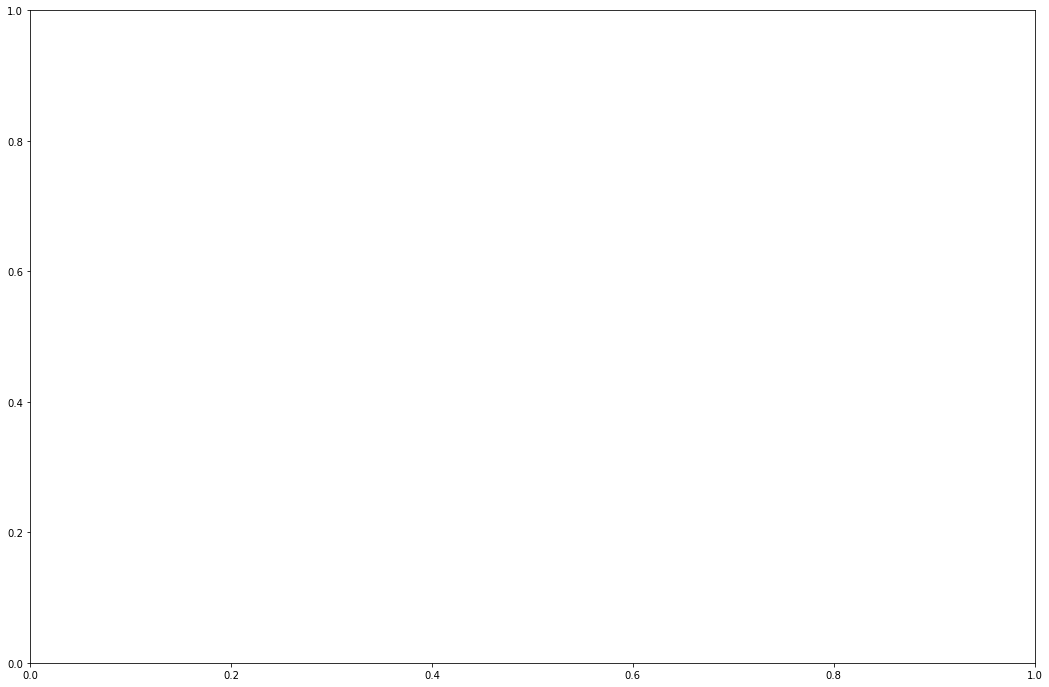

In [228]:
# ICE plots for TN 
fig,ax = plt.subplots(figsize=(18,12))
_=plot_partial_dependence(clf, TNxx, features=X_test.columns, kind='both', ax=ax)

In [197]:
# Only TN and FEATURE column 
TNxx = TNx[['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']]

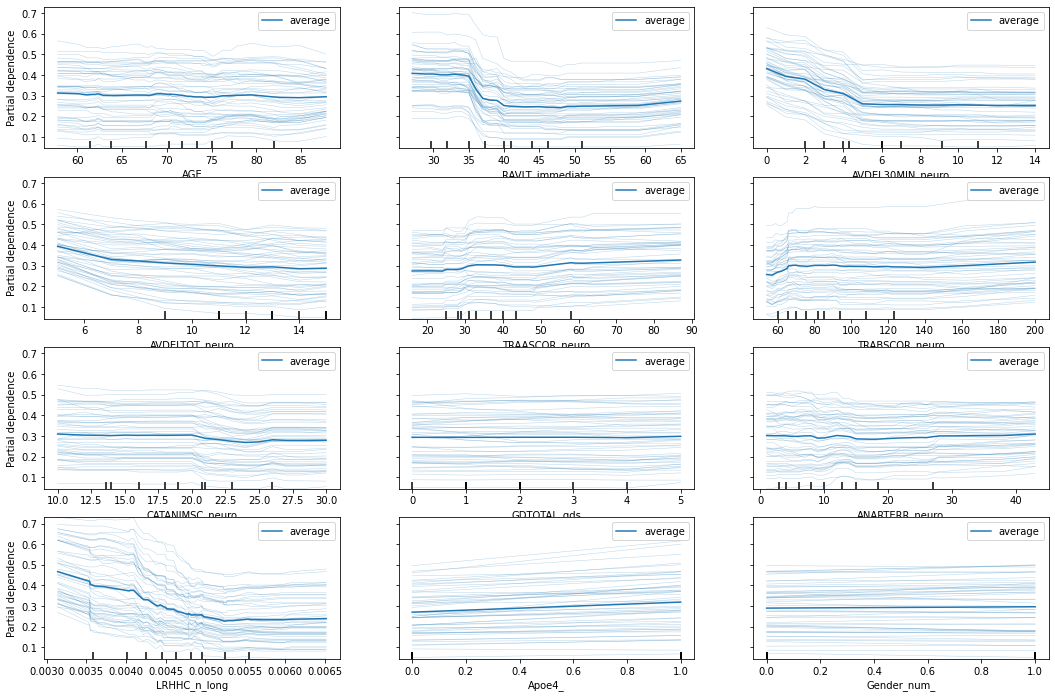

In [198]:
# ICE plots for TN 
fig,ax = plt.subplots(figsize=(18,12))
_=plot_partial_dependence(clf, TNxx, features=X_test.columns, kind='both', ax=ax)

## ICE PLOTS for FP 

In [199]:
FPx = dataSET.loc[dataSET.CM_pred_ == 'FP']
FPx.shape

(22, 141)

In [200]:
FPxx = FPx[['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']]

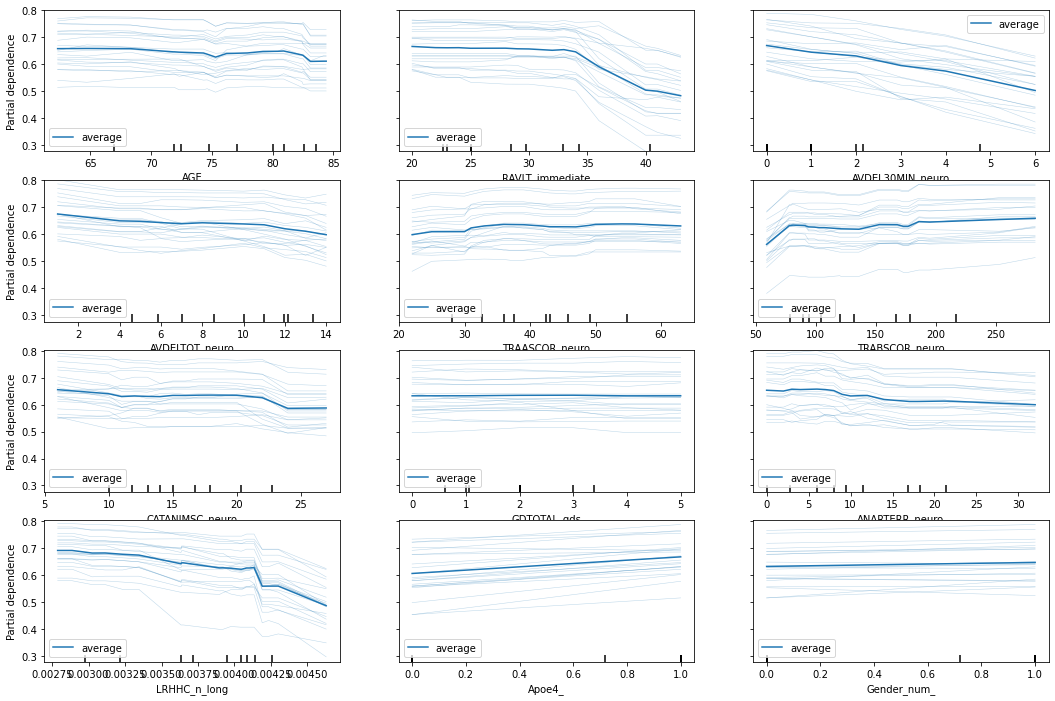

In [201]:
# ICE plots for TN 
fig,ax = plt.subplots(figsize=(18,12))
_=plot_partial_dependence(clf, FPxx, features=X_test.columns, kind='both', ax=ax)

## ICE PLOTS for FN

In [202]:
FNx = dataSET.loc[dataSET.CM_pred_ == 'FN']
FNx.shape

(25, 141)

In [91]:
FNxx = FNx[['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']]

In [ ]:
# ICE plots for TN 
fig,ax = plt.subplots(figsize=(18,12))
_=plot_partial_dependence(clf, FNxx, features=X_test.columns, kind='both', ax=ax)

## ICE PLOTS for TP 

In [92]:
TPx = dataSET.loc[dataSET.CM_pred_ == 'TP']
TPx.shape

(40, 141)

In [93]:
TPxx = TPx[['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']]

In [ ]:
# ICE plots for TN 
fig,ax = plt.subplots(figsize=(18,12))
_=plot_partial_dependence(clf, TPxx, features=X_test.columns, kind='both', ax=ax)


---

Code copied from https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py

Changed features and titles obviously, but also 'est' to 'clf'

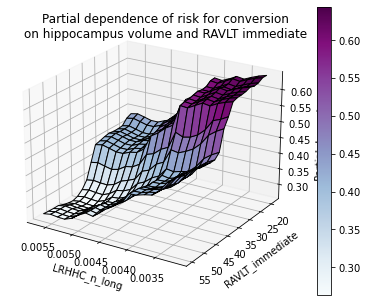

In [203]:
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features = ("LRHHC_n_long", "RAVLT_immediate")
pdp = partial_dependence(
    clf, X_train, features=features, kind="both", grid_resolution=20
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of risk for conversion\n"
    "on hippocampus volume and RAVLT immediate"
)
plt.subplots_adjust(top=0.9)
plt.show()

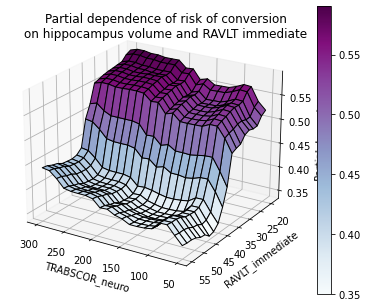

In [204]:
fig = plt.figure()

features = ("TRABSCOR_neuro", "RAVLT_immediate")
pdp = partial_dependence(
    clf, X_train, features=features, kind="average", grid_resolution=20
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of risk of conversion\n"
    "on hippocampus volume and RAVLT immediate"
)
plt.subplots_adjust(top=0.9)
plt.show()

In [205]:
# FEATURE PERMUTATION WITH GROUPS

In [206]:
import mci_info as minfo
import mci_utils as mutils
import mci_freesurfer as mfs
import mci_rf_bl as mrfbl
import mci_permutation as mperm

In [207]:
from sklearn.inspection import permutation_importance

Repetition(s) = 2
Single permutation mode
random_state = 42

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-reps-0001-shuffle-features.png



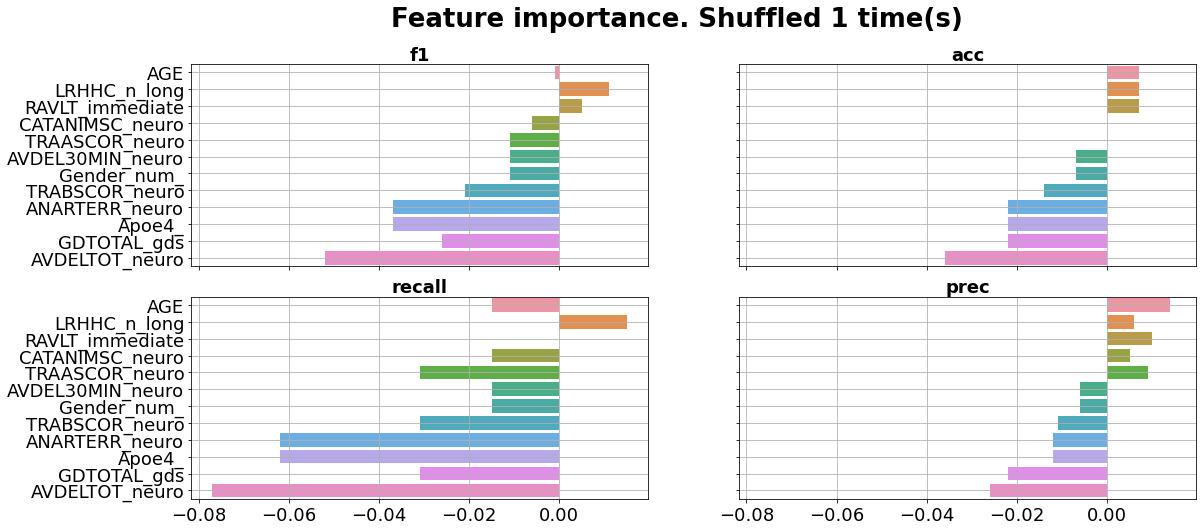

Repetition(s) = 10
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-reps-0010-shuffle-features.png



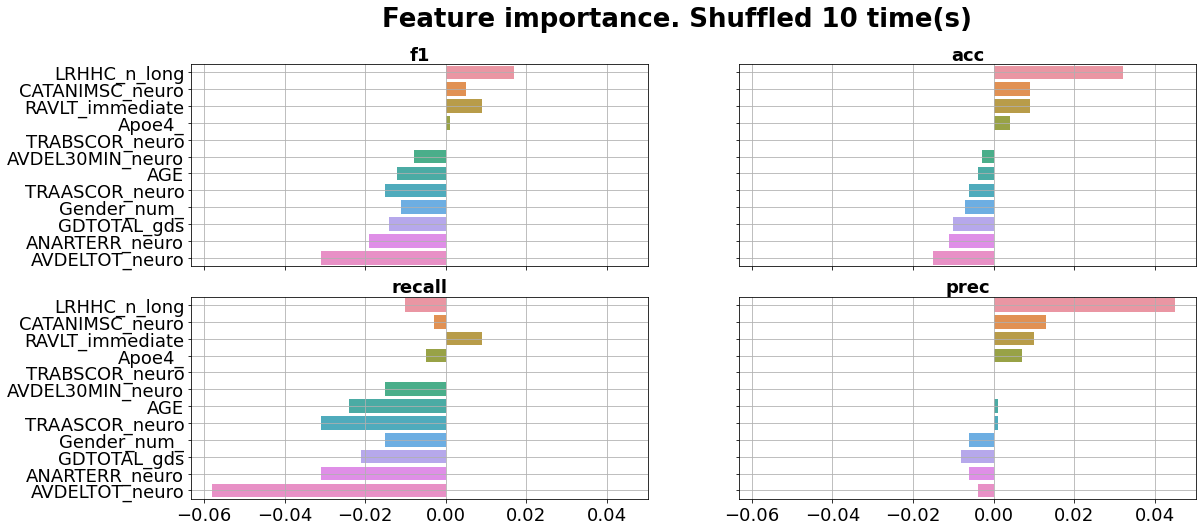

Repetition(s) = 100
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-reps-0100-shuffle-features.png



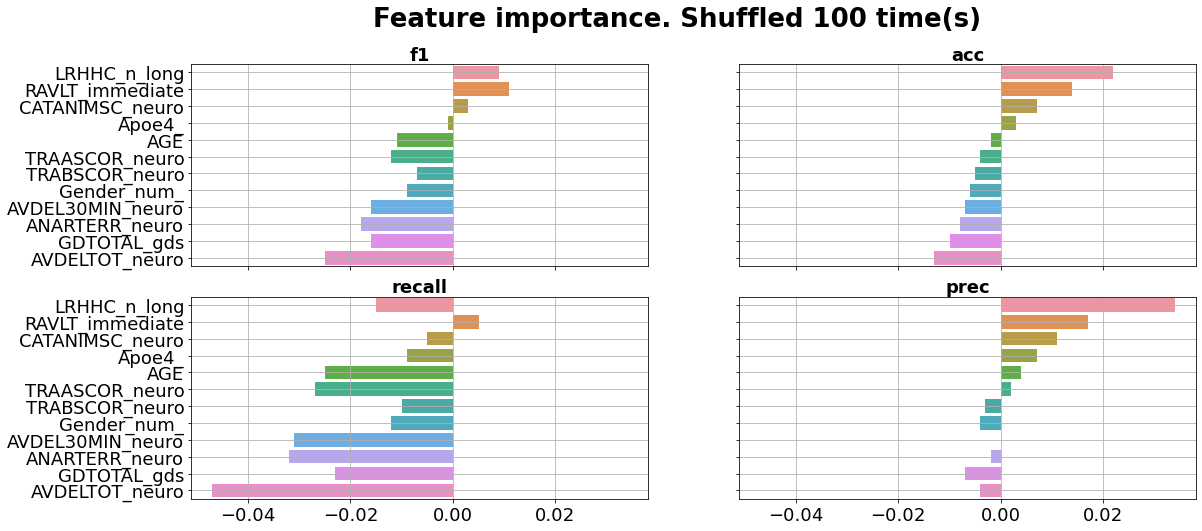

Repetition(s) = 500
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-reps-0500-shuffle-features.png



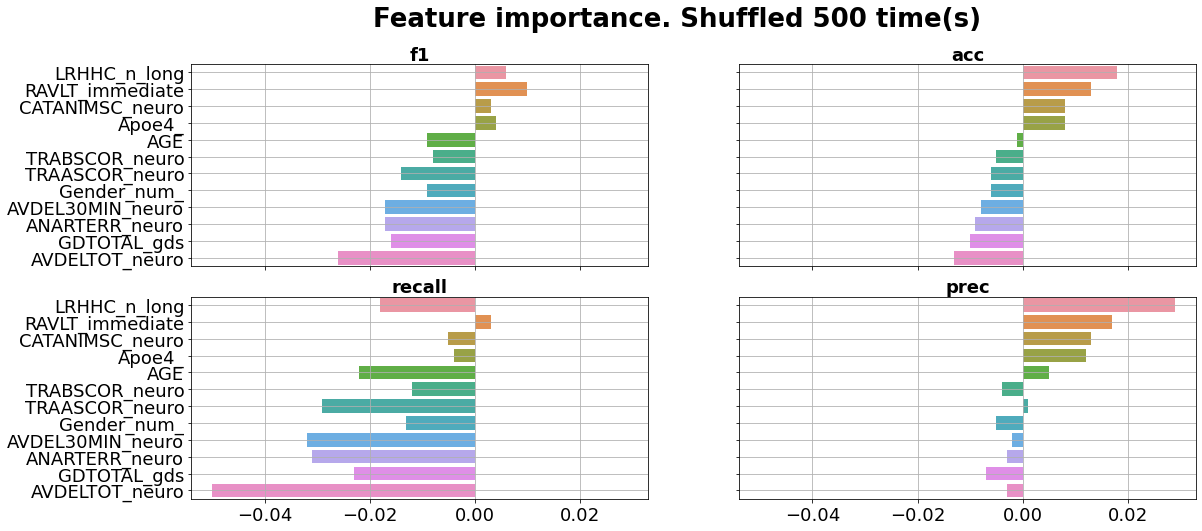

Repetition(s) = 1000
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-reps-1000-shuffle-features.png



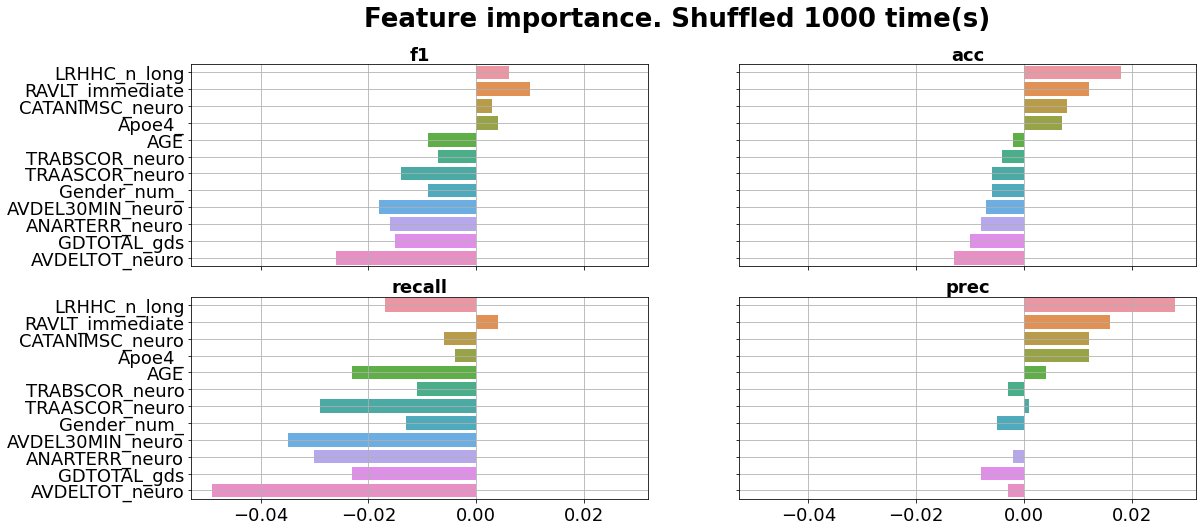

Repetition(s) = 2000
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20211111/3.13_K50_RF_-reps-2000-shuffle-features.png



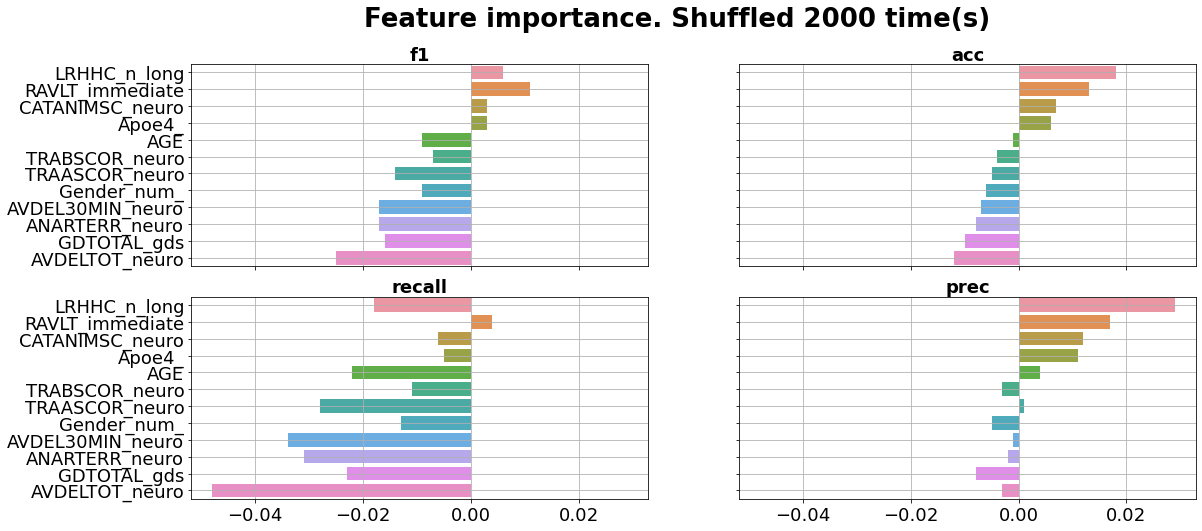

In [208]:
for rep in [0, 9, 99, 499, 999, 1999]:
    df, features = mperm.shuffle_features_with_groups(clf, X_test, y_test,
                                                      precission=3,
                                                      verbose=False,
                                                      random_state=RANDOM_STATE, # only for repetitions=0
                                                      groups=[],
                                                      repetitions=rep,
                                                      sortBy='acc',
                                                      ascending=False)
    #display(df)
    mperm.plot_permuted_features(df,
                                 file_name_prefix=f'{FILE_NAME_PREFIX}-reps-{rep+1:0>4}',
                                 type='shuffle',
                                 title_suffix=f'Shuffled {rep+1} time(s)',
                                 save=True,
                                 results_dir=RESULTS_DIR,
                                 figsize=(18,8)                             
                                )

# FEATURE PERMUTATION WITH GROUPS (x permuations)

In [ ]:
df, features = mperm.shuffle_features_with_groups(clf, X_test, y_test,
                                                  precission=3,
                                                  verbose=True,
                                                  random_state=RANDOM_STATE,
                                                  repetitions=100,
                                                  sortBy='acc',
                                                  ascending=False,
                                                  groups=[['RAVLT_immediate','AVDEL30MIN_neuro', 'AVDELTOT_neuro'],
                                                          ['TRAASCOR_neuro','TRABSCOR_neuro']])
display(df)
mperm.plot_permuted_features(df,
                             file_name_prefix=FILE_NAME_PREFIX,
                             type='shuffle',
                             title_suffix='Shuffled 100 times',
                             save=False,
                             results_dir=RESULTS_DIR,
                             figsize=(18,8)                             
                            )
mperm._print_group_names(features)

In [ ]:
df, features = mperm.shuffle_features_with_groups(clf, X_test, y_test,
                                                  precission=3,
                                                  verbose=True,
                                                  random_state=RANDOM_STATE,
                                                  repetitions=200,
                                                  sortBy='acc',
                                                  ascending=False,
                                                  groups=[['RAVLT_immediate','AVDEL30MIN_neuro', 'AVDELTOT_neuro'],
                                                          ['TRAASCOR_neuro','TRABSCOR_neuro']])
display(df)
mperm.plot_permuted_features(df,
                             file_name_prefix=FILE_NAME_PREFIX,
                             type='shuffle',
                             title_suffix='Shuffled 200 times',
                             save=False,
                             results_dir=RESULTS_DIR,
                             figsize=(18,8)                             
                            )
mperm._print_group_names(features)

# FEATURE PERMUTATION WITH GROUPS (1000 permuations)

In [ ]:
# med 1000 repetitions 
df, features = mperm.shuffle_features_with_groups(clf, X_test, y_test,
                                                  precission=3,
                                                  verbose=True,
                                                  random_state=RANDOM_STATE,
                                                  repetitions=1000,
                                                  sortBy='acc',
                                                  ascending=False,
                                                  groups=[['RAVLT_immediate','AVDEL30MIN_neuro', 'AVDELTOT_neuro'],
                                                          ['TRAASCOR_neuro','TRABSCOR_neuro']])
display(df)
mperm.plot_permuted_features(df,
                             file_name_prefix=FILE_NAME_PREFIX,
                             type='shuffle',
                             title_suffix='Shuffled 1000 times',
                             save=False,
                             results_dir=RESULTS_DIR,
                             figsize=(18,8)                             
                            )
mperm._print_group_names(features)

# DROP SINGLE FEATURE(S)
Here, dropping features that seems to negatively affect model performance from the permuation testing.

In [ ]:
df, features = mperm.dropcol_importances(clf, X_train, y_train, X_test, y_test, precission=2, verbose=True, 
                                                  groups=[['AGE', 'GDTOTAL_gds', 'ANARTERR_neuro', 'Gender_num_']])
display(df)
mperm.plot_permuted_features(df, file_name_prefix=FILE_NAME_PREFIX, type='drop', save=True, results_dir=RESULTS_DIR)
mperm._print_group_names(features)

## Playing with SHAP 

In [65]:
import shap
shap.initjs()

In [66]:
X_test.shape

(139, 12)

In [67]:
y_test.shape

(139,)

In [68]:
features = ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']

In [69]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_split=3,
                       n_estimators=70, random_state=42)

In [70]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)

In [71]:
print(shap_values.values.shape)
print(shap_values.base_values.shape)
print(explainer.expected_value.shape)

(139, 12, 2)
(139, 2)
(2,)


In [72]:
explainer

In [73]:
TeeExplainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

NameError: name 'shap_test' is not defined

In [74]:
explainer = shap.Explainer(clf)
shap_test = explainer(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

Shap values length: 139

Sample shap value:
.values =
array([[-0.00857522,  0.00857522],
       [-0.05366669,  0.05366669],
       [-0.05064737,  0.05064737],
       [-0.01682945,  0.01682945],
       [-0.00861838,  0.00861838],
       [-0.02042693,  0.02042693],
       [-0.0066895 ,  0.0066895 ],
       [ 0.00094283, -0.00094283],
       [ 0.01723793, -0.01723793],
       [-0.08605341,  0.08605341],
       [ 0.01659338, -0.01659338],
       [-0.00898512,  0.00898512]])

.base_values =
array([0.52438378, 0.47561622])

.data =
array([8.04000000e+01, 3.00000000e+01, 1.00000000e+00, 7.00000000e+00,
       4.90000000e+01, 1.68000000e+02, 1.30000000e+01, 0.00000000e+00,
       1.70000000e+01, 3.63758764e-03, 0.00000000e+00, 1.00000000e+00])


In [75]:
print(f"Expected value: {explainer.expected_value[0]:.1f}")
print(f"Average target value (training data): {y_train.mean():.1f}")
print(f"Base value: {np.unique(shap_test.base_values)[0]:.1f}")

Expected value: 0.5
Average target value (training data): 0.5
Base value: 0.5


In [76]:
(shap_test.data == X_test).describe()

AGE RAVLT_immediate AVDEL30MIN_neuro AVDELTOT_neuro TRAASCOR_neuro  \
count    139             139              139            139            139   
unique     1               1                1              1              1   
top     True            True             True           True           True   
freq     139             139              139            139            139   

       TRABSCOR_neuro CATANIMSC_neuro GDTOTAL_gds ANARTERR_neuro LRHHC_n_long  \
count             139             139         139            139          139   
unique              1               1           1              1            1   
top              True            True        True           True         True   
freq              139             139         139            139          139   

       Apoe4_ Gender_num_  
count     139         139  
unique      1           1  
top      True        True  
freq      139         139

In [77]:
pd.DataFrame(shap_test.data, columns=shap_test.feature_names, index=X_test.index)

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
6     80.4             30.0               1.0             7.0            49.0   
82    77.3             29.0               0.0            11.0           122.0   
184   77.5             35.0               1.0            10.0            27.0   
359   71.1             24.0               0.0             2.0            50.0   
384   83.6             30.0               2.0             9.0            22.0   
...    ...              ...               ...             ...             ...   
6238  61.7             65.0              14.0            15.0            29.0   
6244  73.4             44.0               8.0            15.0            43.0   
6261  69.3             49.0               6.0            11.0            24.0   
6267  60.1             51.0              10.0            15.0            28.0   
6309  68.8             29.0               1.0            11.0            28.0   

      TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
6              168.0             13.0          0.0            17.0   
82             151.0             17.0          2.0             3.0   
184             69.0             24.0          2.0            22.0   
359             85.0             13.0          2.0             7.0   
384             76.0             18.0          0.0             9.0   
...              ...              ...          ...             ...   
6238            60.0             22.0          1.0             4.0   
6244            73.0             18.0          3.0             4.0   
6261            99.0             17.0          1.0            43.0   
6267            57.0             22.0          2.0             6.0   
6309            66.0             13.0          1.0             4.0   

      LRHHC_n_long  Apoe4_  Gender_num_  
6         0.003638     0.0          1.0  
82        0.003343     1.0          0.0  
184       0.003149     1.0          1.0  
359       0.003729     0.0          1.0  
384       0.003700     0.0          1.0  
...            ...     ...          ...  
6238      0.005343     0.0          0.0  
6244      0.003991     0.0          0.0  
6261      0.003548     0.0          0.0  
6267      0.005275     0.0          1.0  
6309      0.004956     1.0          1.0  

[139 rows x 12 columns]

In [78]:
shap_df = pd.DataFrame(shap_test.values[:,:,1],
                       columns=shap_test.feature_names,
                      # columns=shap_test.feature_names,
                       index=X_test.index)
shap_df

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  \
6     0.008575         0.053667          0.050647        0.016829   
82   -0.000875         0.036491          0.070653        0.003970   
184   0.003001         0.029329          0.053417        0.009824   
359   0.001393         0.060932          0.077221        0.058514   
384  -0.030209         0.055425          0.032363        0.009733   
...        ...              ...               ...             ...   
6238 -0.004338        -0.077796         -0.071030       -0.018146   
6244 -0.002045        -0.146391         -0.096892       -0.037328   
6261  0.020060        -0.126063         -0.082574       -0.000087   
6267 -0.004507        -0.117351         -0.085603       -0.028272   
6309  0.008207         0.040983          0.062235       -0.011108   

      TRAASCOR_neuro  TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  \
6           0.008618        0.020427         0.006689    -0.000943   
82          0.011850        0.006283         0.005989     0.001399   
184        -0.015546        0.004363        -0.031137     0.001268   
359         0.011258        0.006556         0.003209     0.000522   
384        -0.027199       -0.002926        -0.001761    -0.004533   
...              ...             ...              ...          ...   
6238       -0.017744       -0.028541        -0.018849     0.000051   
6244       -0.001882        0.006906         0.006209    -0.009922   
6261       -0.020637        0.003544         0.009002    -0.001517   
6267       -0.021158       -0.043167        -0.016697    -0.001443   
6309       -0.030690        0.002833         0.004477     0.000602   

      ANARTERR_neuro  LRHHC_n_long    Apoe4_  Gender_num_  
6          -0.017238      0.086053 -0.016593     0.008985  
82          0.029501      0.102570  0.019834    -0.004377  
184        -0.011402      0.112451  0.031563     0.007701  
359         0.020085      0.057542 -0.031293     0.014279  
384         0.004297      0.070319 -0.036082     0.005584  
...              ...           ...       ...          ...  
6238       -0.002750     -0.096063 -0.015352     0.003124  
6244        0.004349      0.035734 -0.028560     0.000226  
6261       -0.002001      0.071723 -0.036851     0.005367  
6267        0.000687     -0.090588 -0.016412     0.000336  
6309        0.012629     -0.140285  0.022819     0.018741  

[139 rows x 12 columns]

In [79]:
np.isclose(clf.predict_proba(X_test)[:,1],
          explainer.expected_value[1] + shap_df.sum(axis=1))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

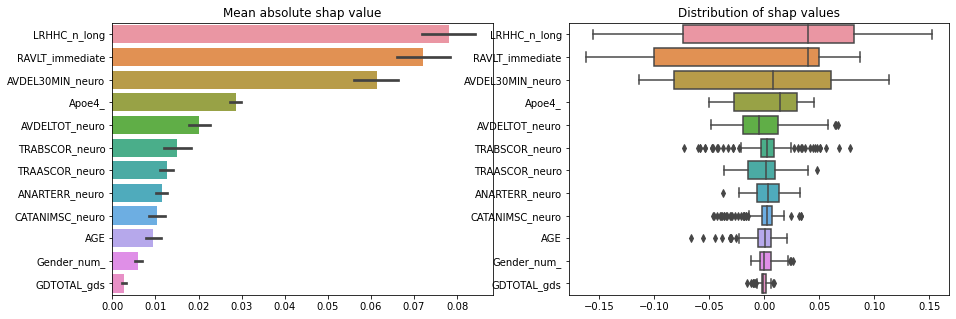

In [80]:
columns = shap_df.apply(np.abs).mean()\
                 .sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
            ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

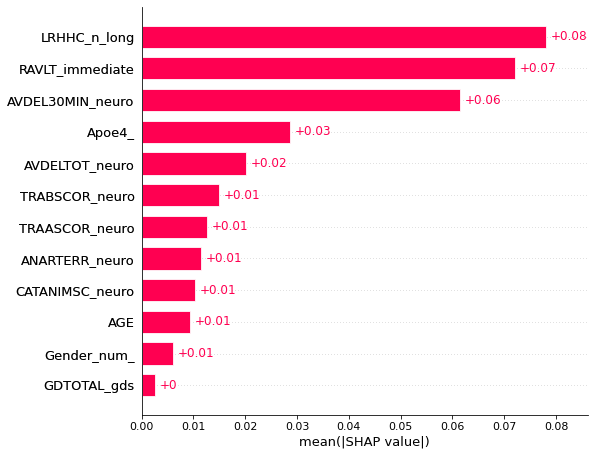

In [81]:
shap.plots.bar(shap_test[:,:,1], max_display=12)

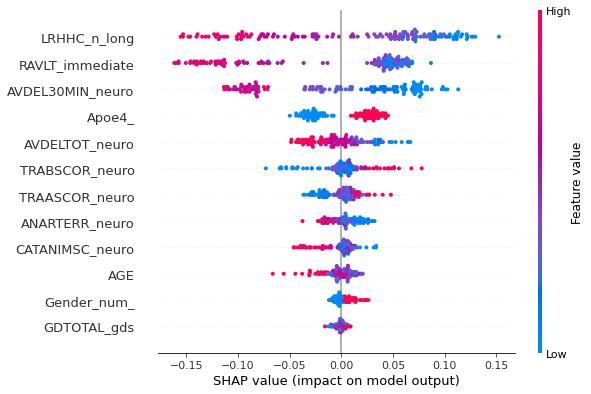

In [84]:
# https://medium.com/analytics-vidhya/shap-part-2-kernel-shap-3c11e7a971b1
shap.summary_plot(shap_values[1], X_test)

Plot over: For cAD output ser vi at:
- lave verdier på hippocampus-volum (i.e. til venstre) øker sannsynligheten for at 'the sample' klassifiseres som cAD.
- lave verdier av RAVLT imm øker sannsynligheten for at samplet klassifiseres som cAD 
- positiv apoe-verdi øker sannsynligheten for at samplet klassifiseres som 

In [91]:
print(type(shap_values[0]))

<class 'numpy.ndarray'>


In [90]:
print(len(shap_values[1]))

139


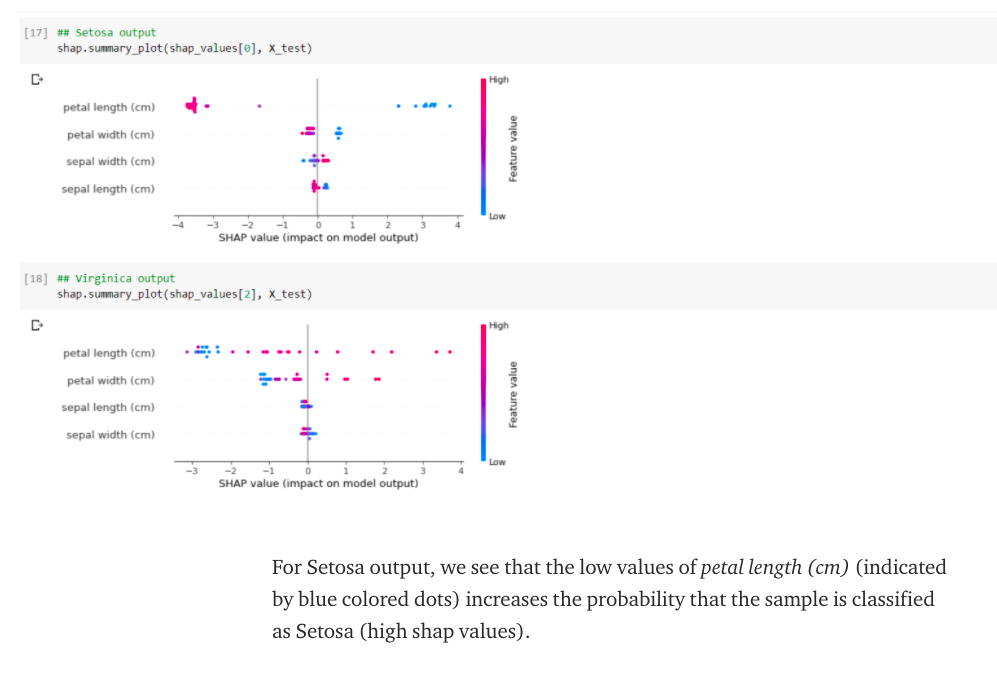

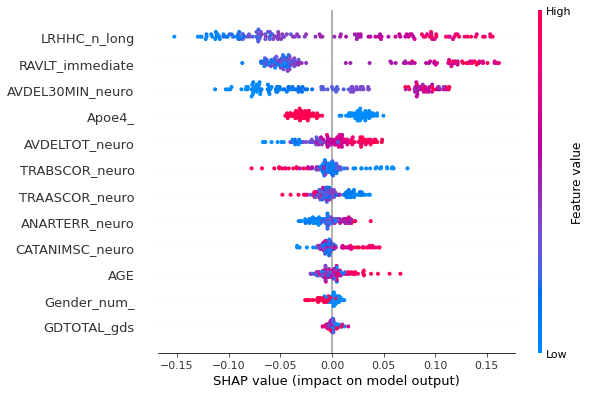

In [82]:
shap.summary_plot(shap_values[0], X_test)

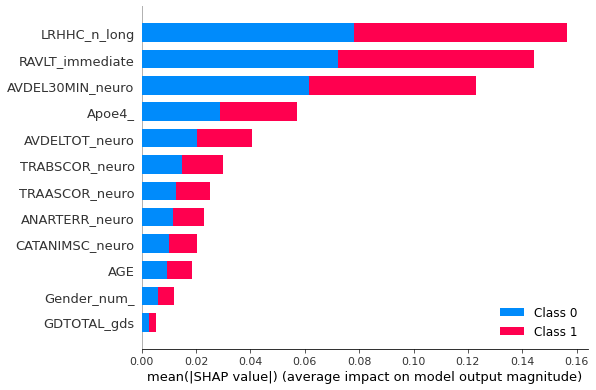

In [83]:
shap.summary_plot(shap_values, X_test)

## Prøver her å lage for TNxx

In [171]:
TNxx.head()

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
834   63.9             39.0               4.0            12.0            24.0   
1068  76.7             51.0              11.0            15.0            58.0   
1526  73.8             45.0               8.0            15.0            28.0   
1612  73.5             33.0               2.0             9.0            38.0   
1863  62.9             48.0               9.0            13.0            39.0   

      TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
834             66.0             14.0          1.0            15.0   
1068           130.0             17.0          1.0            21.0   
1526            54.0             16.0          2.0             3.0   
1612            71.0             26.0          0.0             2.0   
1863           123.0             23.0          1.0             9.0   

      LRHHC_n_long  Apoe4_  Gender_num_  
834       0.003856     1.0            0  
1068      0.003137     0.0            1  
1526      0.004397     0.0            1  
1612      0.004894     0.0            0  
1863      0.004488     0.0            1

In [168]:
explainer = shap.Explainer(clf)
shap_values = explainer(TNxx)

In [169]:
print(shap_values.values.shape)
print(shap_values.base_values.shape)
print(explainer.expected_value.shape)

(52, 12, 2)
(52, 2)
(2,)


In [172]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(TNxx)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

Shap values length: 139

Sample shap value:
.values =
array([[-0.00857522,  0.00857522],
       [-0.05366669,  0.05366669],
       [-0.05064737,  0.05064737],
       [-0.01682945,  0.01682945],
       [-0.00861838,  0.00861838],
       [-0.02042693,  0.02042693],
       [-0.0066895 ,  0.0066895 ],
       [ 0.00094283, -0.00094283],
       [ 0.01723793, -0.01723793],
       [-0.08605341,  0.08605341],
       [ 0.01659338, -0.01659338],
       [-0.00898512,  0.00898512]])

.base_values =
array([0.52438378, 0.47561622])

.data =
array([8.04000000e+01, 3.00000000e+01, 1.00000000e+00, 7.00000000e+00,
       4.90000000e+01, 1.68000000e+02, 1.30000000e+01, 0.00000000e+00,
       1.70000000e+01, 3.63758764e-03, 0.00000000e+00, 1.00000000e+00])


In [173]:
explainer = shap.Explainer(clf)
shap_valuesTNxx = explainer(TNxx)

In [174]:
explainer = shap.Explainer(clf)
shap_testTNxx = explainer(TNxx)
print(f"Shap values length: {len(shap_testTNxx)}\n")
print(f"Sample shap value:\n{shap_testTNxx[0]}")

Shap values length: 52

Sample shap value:
.values =
array([[ 0.00539032, -0.00539032],
       [ 0.09507436, -0.09507436],
       [ 0.02979587, -0.02979587],
       [ 0.01045957, -0.01045957],
       [ 0.02683178, -0.02683178],
       [ 0.00437515, -0.00437515],
       [-0.00645336,  0.00645336],
       [ 0.0005918 , -0.0005918 ],
       [ 0.01378101, -0.01378101],
       [-0.07131637,  0.07131637],
       [-0.03628557,  0.03628557],
       [ 0.00370716, -0.00370716]])

.base_values =
array([0.52438378, 0.47561622])

.data =
array([6.39000000e+01, 3.90000000e+01, 4.00000000e+00, 1.20000000e+01,
       2.40000000e+01, 6.60000000e+01, 1.40000000e+01, 1.00000000e+00,
       1.50000000e+01, 3.85641978e-03, 1.00000000e+00, 0.00000000e+00])


In [175]:
shap_dfTNxx = pd.DataFrame(shap_testTNxx.values[:,:,1],
                       columns=shap_testTNxx.feature_names,
                      # columns=shap_test.feature_names,
                       index=TNxx.index)
shap_dfTNxx.shape

(52, 12)

In [176]:
shap_dfTNxx

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  \
834  -0.005390        -0.095074         -0.029796       -0.010460   
1068  0.002313        -0.130237         -0.097032       -0.027560   
1526 -0.008253        -0.099190         -0.102848       -0.027434   
1612 -0.004704         0.040033          0.031727        0.008546   
1863 -0.004713        -0.150698         -0.091722       -0.019709   
1891 -0.002144        -0.133321         -0.080113       -0.022140   
2108 -0.003975        -0.080135         -0.024510        0.002702   
2225 -0.011625         0.043265          0.028430       -0.006967   
2254 -0.013298        -0.142442         -0.097064       -0.029095   
2580  0.009045         0.041063          0.000034        0.020494   
3267 -0.008565        -0.131549         -0.082372       -0.028106   
3419 -0.037911         0.052375         -0.018966       -0.026080   
3458  0.002919        -0.113486         -0.080791       -0.013009   
3750 -0.004404        -0.140234         -0.098286       -0.037510   
3761  0.003616        -0.017856         -0.082730       -0.019432   
3794  0.003988         0.051270         -0.023782       -0.006936   
3917  0.006267        -0.121701         -0.093587       -0.020161   
3981 -0.006212        -0.077528         -0.104399       -0.048314   
4057 -0.001936        -0.075315          0.004266       -0.003466   
4068  0.006139         0.032404          0.030222       -0.002335   
4096 -0.002983         0.068645         -0.084317       -0.007946   
4127  0.013819        -0.112793         -0.081700       -0.015045   
4158 -0.010272        -0.101827         -0.089409       -0.035090   
4260 -0.016890         0.058677         -0.004048        0.013438   
4324 -0.004742         0.036176         -0.080447       -0.001348   
4458  0.014654        -0.070904         -0.083012       -0.037080   
4549  0.004851         0.048140         -0.016112        0.030526   
4721 -0.008807        -0.139892         -0.113280       -0.019773   
4745  0.000948         0.044702         -0.011341       -0.008209   
4859 -0.004192        -0.113598         -0.075005       -0.029005   
4868  0.006220        -0.117937         -0.091482       -0.040093   
4899  0.001649        -0.061717         -0.082537       -0.032097   
4980  0.004788         0.040962          0.054339        0.010020   
5124 -0.001921         0.047811         -0.027607       -0.009634   
5167  0.009469        -0.100432         -0.087960       -0.009338   
5191  0.006065        -0.091138         -0.071435       -0.033463   
5264 -0.002385        -0.115732         -0.023186       -0.004225   
5370 -0.030504         0.063165         -0.094300        0.004125   
5468 -0.019139        -0.157603         -0.113731       -0.012739   
5557 -0.002515        -0.135769         -0.019527       -0.041063   
5565 -0.003428        -0.146042          0.102808        0.002153   
5613  0.000129         0.034916          0.097288        0.014237   
5769 -0.005859        -0.119778         -0.090340       -0.016433   
5809  0.003232        -0.127092         -0.074068       -0.037952   
5865  0.004547        -0.160215         -0.100908       -0.029430   
6022  0.001164        -0.157661         -0.019697       -0.009721   
6099 -0.005325        -0.119520         -0.093782       -0.032423   
6210 -0.002942         0.032027          0.028991       -0.009835   
6238 -0.004338        -0.077796         -0.071030       -0.018146   
6261  0.020060        -0.126063         -0.082574       -0.000087   
6267 -0.004507        -0.117351         -0.085603       -0.028272   
6309  0.008207         0.040983          0.062235       -0.011108   

      TRAASCOR_neuro  TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  \
834        -0.026832       -0.004375         0.006453    -0.000592   
1068        0.017461       -0.006467         0.005439    -0.003729   
1526       -0.015349       -0.036942         0.006199     0.001490   
1612        0.015927        0.002337        -0.024054     0.000138   
186

In [177]:
np.isclose(clf.predict_proba(TNxx)[:,1],
          explainer.expected_value[1] + shap_dfTNxx.sum(axis=1))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [178]:
shap.summary_plot(shap_valuesTNxx[1], TNxx)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [179]:
X_test.shape

(139, 12)

In [180]:
TNxx.shape

(52, 12)

In [181]:
columns = shap_df.apply(np.abs).mean()\
                 .sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
            ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

NameError: name 'shap_df' is not defined

In [55]:
dataSET = pd.read_csv('../Ingrid/pycaret_K50/RF_K50_final_df_best_blended_top5_K50.csv', index_col=0)
dataSET.shape

(139, 141)

In [75]:
# Som med individuelle ICE plots for pred.class må vi først ordne data for hver gruppe 
TNx = dataSET.loc[dataSET.CM_pred_ == 'TN']
TNx.shape

(52, 141)

In [57]:
# Only TN and FEATURE column 
TNxx = TNx[['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']]

In [58]:
explainer = shap.TreeExplainer(clf)
shap_valuesTN = explainer.shap_values(TNxx, check_additivity=False)

NameError: name 'shap' is not defined

In [109]:
# Setting feature_perturbation = "tree_path_dependent" because no background data was given
# check the first obvs of iris
dfSHAP.iloc[0]

AGE                  80.000000
RAVLT_immediate      36.000000
AVDEL30MIN_neuro      1.000000
AVDELTOT_neuro        8.000000
TRAASCOR_neuro       47.000000
TRABSCOR_neuro      139.000000
CATANIMSC_neuro      16.000000
GDTOTAL_gds           1.000000
ANARTERR_neuro        4.000000
LRHHC_n_long          0.003458
Apoe4_                0.000000
Gender_num_           1.000000
Name: 13, dtype: float64

In [110]:
# plot the single observation's influence on prediction
shap.force_plot(explainer.expected_value[0], shap_values[0][0], dfSHAP.iloc[0])

In [90]:
pycharet.columns

Index(['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Subgroup_',
       'Subgroup_num_', 'Usage_', 'PTGENDER', 'Gender_num_'],
      dtype='object')

In [91]:
dfSHAP = pycharet[['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']]

In [92]:
dfSHAP.head()

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
13  80.0             36.0               1.0             8.0            47.0   
26  76.8             27.0               5.0            10.0            61.0   
29  70.9             22.0               0.0             0.0            18.0   
37  72.8             29.0               1.0             8.0            40.0   
55  77.6             30.0               2.0            14.0           150.0   

    TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
13           139.0             16.0          1.0             4.0   
26           300.0             19.0          4.0            23.0   
29           145.0             18.0          2.0            12.0   
37           101.0             17.0          1.0             6.0   
55           300.0             12.0          0.0             9.0   

    LRHHC_n_long  Apoe4_  Gender_num_  
13      0.003458     0.0            1  
26      0.005251     0.0            0  
29      0.003026     1.0            1  
37      0.002767     0.0            0  
55      0.002814     0.0            0

In [93]:
#importing shap package
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(dfSHAP, check_additivity=False)

### These SHAP values are based on this notebook
https://github.com/franknb/Medium/blob/master/Feature_Importance/Feature_importance.ipynb
and this article https://towardsdatascience.com/a-relook-on-random-forest-and-feature-importance-2467dfab5cca

In [83]:
# Setting feature_perturbation = "tree_path_dependent" because no background data was given
# check the first obvs of iris
dfSHAP.iloc[0]

NameError: name 'dfSHAP' is not defined

In [95]:
# plot the single observation's influence on prediction
shap.force_plot(explainer.expected_value[0], shap_values[0][0], dfSHAP.iloc[0])

## DETTE ER DELTAGERNE SOM AV RF BLE MISFLASSIFISERT SOM FP

In [96]:
# plot the single observation's influence on prediction
shap.force_plot(explainer.expected_value[0], shap_values[0][0], dfSHAP.iloc[138])

In [97]:
# plot the single observation's influence on prediction
shap.force_plot(explainer.expected_value[0], shap_values[0][0], dfSHAP.iloc[118])

## DETTE ER DELTAGERNE SOM AV RF BLE MISFLASSIFISERT SOM FN

In [ ]:
# plot the single observation's influence on prediction
shap.force_plot(explainer.expected_value[0], shap_values[0][0], dfSHAP.iloc[4])

In [ ]:
# plot the single observation's influence on prediction
shap.force_plot(explainer.expected_value[0], shap_values[0][0], dfSHAP.iloc[12])

In [ ]:
# plot the single observation's influence on prediction
shap.force_plot(explainer.expected_value[0], shap_values[0][0], dfSHAP.iloc[35])

In [ ]:
# plot all observations' influence on prediction
shap.force_plot(explainer.expected_value[0], shap_values[0], dfSHAP)

In [ ]:
# feature importance of iris based on shap value
shap.summary_plot(shap_values, dfSHAP, plot_type="bar")

# COPYING ALEXANDRAS TEST FOR SHAP VALUES
This aritcles is really good: https://towardsdatascience.com/visualizing-ai-8fad4ea70b87

In [ ]:
import shap

import numpy as np
np.set_printoptions(formatter={'float':lambda x:"{:.4f}".format(x)})
import pandas as pd
pd.options.display.float_format = "{:.3f}".format
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='rainbow')

shap.initjs()

In [ ]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)

In [ ]:
print(shap_values.values.shape)
print(shap_values.base_values.shape)
print(explainer.expected_value.shape)

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

In [ ]:
# Printing shape of data 
print("Training features shape:", X_train.shape)
print("Training target shape:", X_test.shape)
print()
print("Test features shape:",y_train.shape)
print("Test target shape",y_test.shape)

In [ ]:
explainer = shap.Explainer(clf)
shap_test = explainer(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print("*****************************************")
print(f"Sample shap values:\n{shap_test[0]}")

Explanations regarding the cell abode:
- The length of shap_test is 139 because it contains a record for each test instance (i.e. patient in TEST set) 
- Built into shap_test there are three metrics (NB! Displayed here for subject with index==0 is displayed)
    - **shap_test[0].base_values is Base values for target**: this is also known as the expected value (explainer.expected_value), tells us the probability of for each class (for regression problems), whereas in classification models this tells us the probability for each class. We will focus on the positive class (i.e. y == 1, convertion to AD. Not to self: finne ut hva det betyre å "focuse on the positive class". 
    - **shap_test[0.data**: value for each feature]
    - **shap_test[0].values**: Shap values for each features

In [ ]:
print(f"Expected value: {explainer.expected_value[1]:.2f}")
print(f"Average target value (training data): {y_train.mean():.2f}")
print(f"Base value: {np.unique(shap_test.base_values)[0]:.2}")

In [ ]:
(shap_test.data == X_test).describe()

In [ ]:
# Converting to data frame
pd.DataFrame(shap_test.data, columns=shap_test.feature_names, 
             index=X_test.index)

In [ ]:
shap_df = pd.DataFrame(shap_test.values[:,:,0],
                       columns=shap_test.feature_names,
                       index=X_test.index)
shap_df

In [ ]:
# We can see the shap values by feature for each record. If we add these shap values to the expected value, we will get the prediction:
# Dette skal (i følge notebooken) være |True| ikke |False|, men troooooor kanskje det er relatert til at notboken i dette tilfellet snakket om regression og ikke klassifikasjon. 
np.isclose(clf.predict(X_test), 
           explainer.expected_value[0] + shap_df.sum(axis=1))

In [ ]:
# The left subplot shows the mean absolute shap value for each feature whereas the right subplot shows the distribution of the shap values by feature. 
# One takeaway from these graphs is that RAVLT_immediate has the biggest contribution among the 12 features being used.


columns = shap_df.apply(np.abs).mean()\
                 .sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(11,4))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
            ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

In [ ]:
shap.summary_plot(shap_test)

In [ ]:
print(type(X_train))

In [ ]:
numpy_array = X_train.to_numpy()

In [ ]:
shap.plots.bar(numpy_array)

In [ ]:
shap.summary_plot(numpy_array)

In [ ]:
X_train.head()

In [ ]:
array = X_train.to_records(index=True)

In [ ]:
#print(array)

---

### EXPLORING THE CHARACTERISTICS WITH THE FOUR CLASSES (TN, FP, FN, TP) 

In [ ]:
# This datafile contains data from participants in test set ('Usage_'==test), as well well how they were classified. 
predictions_bl = pd.read_csv('../results/20211111/3.12_RF-TEST-predictions.csv')
predictions_bl.head()

In [ ]:
predictions_bl.columns

### Stealing (and modifiing) Mareks function for box and violin plots

In [ ]:
def plot_violin_box_feature_vs_classification(df, feature_name='AGE', **kw):
    """
    Plots violin and box plot figures of feature vs. Classification 
    
    Changes: Additional parameter: title, by deafault figure title was assumed as feature name.
            There is possibility to set any title.
            
    
    Parameters:
    -------------
    df - data frame, a table to take features from (a pandas dataframe),
    feature_name - name of a feature to plot (a string, default: 'AGE')
    
    Optional:
    ----------
    title - a figure title (a string, dafault: feature_name vs. Subgroup)
    points - weather or not to plot jitter dots (a boolean value, default:True)
    figsize - figure size (a tuple with size, deafault: (16,8))
    
    
    x_label - x axis label (a string, default: 'Subgroup')
    x_label_size - x label font size (an inteager, default: 28)
    x_label_labelpad - x label distance from axis (an inteager, default:20)
    
    y_label - y axis label (a string, default: feature_name)
    y_label_size - y label font size (an inteager, default: 28)
    y_label_labelpad - y label distance from axis (an inteager, default:20)
    
    grid_on - turn on/off a grid (a boolean value, default: True)
    
    subplot_adj - adjust subplot spaces (a list with float numbers).
                Usage:  (left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2,  hspace=0.35)
                Parameters:
                - sub_left
                - sub_bottom
                - sub_right
                - sub_top
                - sub_wspace
                - sub_hspace
                
    
    Created 2020.11.15 / Updated 2021.03.04
    """    
    title = kw.get('title', f'{feature_name} vs. Subgroup')
    points = kw.get('points', True)
    figsize = kw.get('figsize', (16,8))
    
    x_label = kw.get('x_label', 'Subgroup')
    x_label_size = kw.get('x_label_size', 28)
    x_label_labelpad = kw.get('x_label_labelpad', 10)
    
    y_label = kw.get('y_label', feature_name)
    y_label_size = kw.get('y_label_size', 28)
    y_label_labelpad = kw.get('y_label_labelpad', 10)
    
    # (left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2,  hspace=0.35)
    sub_left = kw.get('sub_left', 0.05)
    sub_bottom = kw.get('sub_bottom', 0.05)
    sub_right = kw.get('sub_right', 0.95)
    sub_top = kw.get('sub_top', 0.9)
    sub_wspace = kw.get('sub_wspace', 0.05)
    sub_hspace = kw.get('sub_hspace', 0.05)
    
    figSaveName = kw.get('figSaveName', '')
    
    
    grid_on = kw.get('grid', True)
        
    
    #title = title if title else f'{feature_name} vs. Subgroup'
    violin, ax = plt.subplots(1,2, figsize=figsize, sharex=True, sharey=True)
    
    _ = plt.suptitle(title, fontsize=26, weight='bold')
    
    _ = sns.violinplot(x='CM_pred_', y=feature_name, hue='PTGENDER', data=df, split=True, ax=ax[0])
    if points:
        _ = sns.stripplot(x="CM_pred_", y=feature_name, hue='PTGENDER', data=df, dodge=True, palette='dark',ax=ax[0])
        
    _ = sns.boxplot(x='CM_pred_', y=feature_name, hue='PTGENDER', data=df,  ax=ax[1])
    

    for a in ax:
        a.set_xlabel(x_label, fontsize=x_label_size, weight='bold', labelpad=x_label_labelpad)
        a.set_ylabel(y_label, fontsize=y_label_size, weight='bold', labelpad=y_label_labelpad)
        
        a.tick_params(axis='both', which='major', labelsize=20)
        a.tick_params(axis='both', which='minor', labelsize=20)
        
        handles, labels = a.get_legend_handles_labels()
        a.legend(handles[0:2], labels[0:2],loc=8, prop={'size': 16})        
        a.grid(grid_on)    
        
    ax[1].set(ylabel=None)
    

### Plotting

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='RAVLT_immediate', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='LRHHC_n_long', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='AVDEL30MIN_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='TRABSCOR_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='CATANIMSC_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='AVDELTOT_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='AGE', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='TRAASCOR_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='ANARTERR_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='GDTOTAL_gds', points=True)

In [ ]:
matplotlib.pyplot.bar(, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)

------

### Descriptive statistic for sMCI and cAD subgrup

In [ ]:
pwd

In [ ]:
Xy_train = pd.read_csv('../results/20211111/3.12_Xy_train.csv')

In [ ]:
Xy_train.head()